In [1]:
# ==========================================================
# 🧠 BLOQUE 0 — Configuración e Importaciones
# ==========================================================

import pandas as pd
import numpy as np
import requests
import plotly.graph_objects as go
import time
from datetime import datetime, timedelta
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from itertools import product
import plotly.express as px
from joblib import Parallel, delayed
from tqdm import tqdm
import os
import itertools
import concurrent.futures as cf
from concurrent.futures import ThreadPoolExecutor, as_completed

# --- Configuración general ---
pd.set_option('display.max_columns', None)
pd.set_option('display.precision', 6)

# --- Parámetros base ---
BASE_URL = "https://api.binance.com"
TIMEZONE = "America/Costa_Rica"
INTERVAL = "4h"
LIMIT = 1000  # número de velas (~6 meses)


In [2]:
# ==========================================================
# 🧩 BLOQUE 0.1 — Descarga rápida de velas para Take Profit Tester
# ==========================================================


BASE_URL = "https://api.binance.com"
symbols = ["BTCUSDT", "ETHUSDT", "ADAUSDT", "XRPUSDT", "BNBUSDT"]
limit = 1000  # ~6 meses de velas 4h

def get_binance_4h_data(symbol: str, limit: int = 1000) -> pd.DataFrame:
    url = f"{BASE_URL}/api/v3/klines"
    params = {"symbol": symbol, "interval": "4h", "limit": limit}
    r = requests.get(url, params=params)
    r.raise_for_status()
    data = r.json()

    cols = [
        "Open time","Open","High","Low","Close","Volume",
        "Close time","Quote asset volume","Number of trades",
        "Taker buy base asset volume","Taker buy quote asset volume","Ignore"
    ]
    df = pd.DataFrame(data, columns=cols)

    # Conversión de tipos y formato
    for c in ["Open","High","Low","Close","Volume"]:
        df[c] = pd.to_numeric(df[c], errors="coerce")

    df["Open time"] = pd.to_datetime(df["Open time"], unit="ms", utc=True).dt.tz_convert("America/Costa_Rica")
    df["Close time"] = pd.to_datetime(df["Close time"], unit="ms", utc=True).dt.tz_convert("America/Costa_Rica")

    df = df.sort_values("Open time").reset_index(drop=True)
    return df

def fetch_symbol_data(symbol):
    print(f"📥 Descargando {symbol} ...")
    df = get_binance_4h_data(symbol, limit)
    print(f"✅ {symbol}: {len(df)} velas descargadas.")
    return symbol, {"df": df}

# Descargar en paralelo
data_full = {}
with ThreadPoolExecutor(max_workers=len(symbols)) as ex:
    futures = [ex.submit(fetch_symbol_data, s) for s in symbols]
    for f in as_completed(futures):
        sym, info = f.result()
        data_full[sym] = info

print(f"\n💾 Dataset descargado correctamente: {len(data_full)} símbolos disponibles.")


📥 Descargando BTCUSDT ...
📥 Descargando ETHUSDT ...
📥 Descargando ADAUSDT ...
📥 Descargando XRPUSDT ...
📥 Descargando BNBUSDT ...
✅ BTCUSDT: 1000 velas descargadas.
✅ ETHUSDT: 1000 velas descargadas.
✅ XRPUSDT: 1000 velas descargadas.
✅ BNBUSDT: 1000 velas descargadas.
✅ ADAUSDT: 1000 velas descargadas.

💾 Dataset descargado correctamente: 5 símbolos disponibles.


In [3]:
# ==========================================================
# 📥 BLOQUE 1 — Descarga de velas (4H) desde Binance
# ==========================================================

def get_binance_4h_data(symbol: str, limit: int = LIMIT) -> pd.DataFrame:
    """
    Descarga datos OHLCV de Binance (intervalo 4H)
    y devuelve un DataFrame ordenado y tipado correctamente.
    """
    url = f"{BASE_URL}/api/v3/klines"
    params = {"symbol": symbol, "interval": INTERVAL, "limit": limit}
    r = requests.get(url, params=params)
    r.raise_for_status()
    data = r.json()

    cols = [
        "Open time", "Open", "High", "Low", "Close", "Volume",
        "Close time", "Quote asset volume", "Number of trades",
        "Taker buy base asset volume", "Taker buy quote asset volume", "Ignore"
    ]
    df = pd.DataFrame(data, columns=cols)

    # Conversión de tipos
    for c in ["Open", "High", "Low", "Close", "Volume"]:
        df[c] = pd.to_numeric(df[c], errors="coerce")

    # Conversión de timestamps y orden
    df["Open time"]  = pd.to_datetime(df["Open time"],  unit="ms", utc=True).dt.tz_convert(TIMEZONE)
    df["Close time"] = pd.to_datetime(df["Close time"], unit="ms", utc=True).dt.tz_convert(TIMEZONE)
    df = df.sort_values("Open time").reset_index(drop=True)

    return df


# --- Ejemplo de prueba ---
symbol = "BTCUSDT"
df = get_binance_4h_data(symbol, limit=500)
display(df.head(3))
print(f"✅ {symbol}: {len(df)} velas descargadas correctamente.")


,Open time,Open,High,Low,Close,Volume,Close time,Quote asset volume,Number of trades,Taker buy base asset volume,Taker buy quote asset volume,Ignore
0,2025-08-13 06:00:00-06:00,120570.41,122200.00,120106.02,120920.62,7228.67197,2025-08-13 09:59:59.999000-06:00,876073760.93010120,1223418,3448.06635000,417943044.85693230,0
1,2025-08-13 10:00:00-06:00,120920.61,122839.47,120920.61,122744.21,4167.90157,2025-08-13 13:59:59.999000-06:00,508080168.05941110,716576,2589.17326000,315617346.50495580,0
2,2025-08-13 14:00:00-06:00,122744.22,123667.79,122298.20,123306.43,3915.20787,2025-08-13 17:59:59.999000-06:00,481487822.00229430,638125,1992.36824000,245097965.40922940,0


✅ BTCUSDT: 500 velas descargadas correctamente.


In [4]:
# ==========================================================
# ⚙️ BLOQUE 2 — Indicadores base: Momentum Integral
# ==========================================================

def calcular_momentum_integral(df, window=8, smooth=3):
    df = df.copy()
    df["momentum"] = df["Close"].diff()
    df["momentum_smooth"] = df["momentum"].rolling(window=smooth, min_periods=1).mean()
    df["integral_momentum"] = df["momentum_smooth"].rolling(window=window).sum()
    df["slope_integral"] = df["integral_momentum"].diff()
    std_slope = df["slope_integral"].rolling(window=window).std()

    df["Signal Final"] = np.select(
        [
            (df["slope_integral"] < -std_slope) & (df["momentum_smooth"] < 0),
            (df["slope_integral"] > std_slope) & (df["momentum_smooth"] > 0)
        ],
        ["SELL", "BUY"],
        default=None
    )
    return df



def limpiar_señales_persistentes(df, columna="Signal Final"):
    """
    Elimina señales repetidas del mismo tipo, conservando solo el cambio de dirección.
    """
    df = df.copy().reset_index(drop=True)
    df["Signal Limpia"] = None
    last_signal = None

    for i in range(len(df)):
        current = df.at[i, columna]
        if current in ["BUY", "SELL"]:
            if current != last_signal:
                df.at[i, "Signal Limpia"] = current
                last_signal = current
    return df


# --- Aplicar al dataset ---
df = calcular_momentum_integral(df, window=8)
df = limpiar_señales_persistentes(df)

display(df[["Open time", "Close", "Signal Final", "Signal Limpia"]].tail(20))


,Open time,Close,Signal Final,Signal Limpia
480,2025-11-01 06:00:00-06:00,110310.65,None,None
481,2025-11-01 10:00:00-06:00,110299.99,None,None
482,2025-11-01 14:00:00-06:00,110098.10,None,None
483,2025-11-01 18:00:00-06:00,110053.23,None,None
484,2025-11-01 22:00:00-06:00,110895.53,None,None
485,2025-11-02 02:00:00-06:00,111196.99,None,None
486,2025-11-02 06:00:00-06:00,110117.48,None,None
487,2025-11-02 10:00:00-06:00,110180.84,None,None
488,2025-11-02 14:00:00-06:00,110540.68,None,None
489,2025-11-02 18:00:00-06:00,107937.45,SELL,SELL


In [5]:
# ==========================================================
# 🎯 BLOQUE 3 — Métodos de cálculo de TP / SL
# ==========================================================

def calcular_tp_sl(entry_price, df, metodo="RR", rr=1.5):
    """
    Calcula Stop Loss y Take Profit según el método seleccionado.
    Métodos disponibles: 'RR', 'ATR', 'Momentum', 'Estructura'
    """
    df = df.copy()
    atr = (df["High"] - df["Low"]).rolling(window=14).mean().iloc[-1]
    swing_low = df["Low"].rolling(window=10).min().iloc[-1]
    swing_high = df["High"].rolling(window=10).max().iloc[-1]
    momentum = df["momentum"].iloc[-1] if "momentum" in df else 0

    if metodo == "RR":
        # Risk-Reward fijo
        stop_loss = entry_price * (1 - 0.01 * rr)
        take_profit = entry_price * (1 + 0.015 * rr)

    elif metodo == "ATR":
        # Basado en volatilidad (Average True Range)
        stop_loss = entry_price - atr * 1.5
        take_profit = entry_price + atr * 2.5

    elif metodo == "Momentum":
        # Basado en la fuerza del momentum integral
        factor = np.clip(momentum / entry_price, -0.02, 0.02)
        stop_loss = entry_price * (1 - 0.8 * abs(factor))
        take_profit = entry_price * (1 + 2.5 * abs(factor))

    elif metodo == "Estructura":
        # Basado en niveles de estructura
        stop_loss = swing_low
        take_profit = swing_high * 0.995

    else:
        raise ValueError("Método no reconocido. Usa: 'RR', 'ATR', 'Momentum' o 'Estructura'.")

    return round(stop_loss, 3), round(take_profit, 3)


# --- Ejemplo de prueba ---
entry_example = df["Close"].iloc[-1]
sl, tp = calcular_tp_sl(entry_example, df, metodo="ATR")
print(f"💵 Entrada: {entry_example:.2f} | SL={sl:.2f} | TP={tp:.2f}")


💵 Entrada: 101350.65 | SL=98708.98 | TP=105753.44


In [6]:
# ==========================================================
# 🧮 BLOQUE 4 — Simulación de resultados (TP / SL Tester) — Versión Long-Only
# ==========================================================

def simular_trade(df, i, metodo="ATR", rr=1.5, max_barras=40):
    """
    Simula un trade LONG (solo BUY) a partir de la señal en el índice i.
    Cierra si se alcanza el TP, el SL o aparece una señal SELL.
    """
    if df.at[i, "Signal Limpia"] != "BUY":
        return None  # Solo operamos BUY

    entry_price = df.at[i, "Close"]
    sl, tp = calcular_tp_sl(entry_price, df.iloc[:i+1], metodo=metodo, rr=rr)

    # Subset futuro
    future = df.iloc[i+1:i+1+max_barras].copy()
    if len(future) == 0:
        return None

    # Variables de control
    hit_tp = False
    hit_sl = False
    closed_by_sell = False

    for j in range(len(future)):
        high = future.iloc[j]["High"]
        low = future.iloc[j]["Low"]
        signal = future.iloc[j]["Signal Limpia"]

        # 1️⃣ Check TP/SL
        if not hit_tp and high >= tp:
            hit_tp = True
            exit_price = tp
            motivo = "TP"
            break
        if not hit_sl and low <= sl:
            hit_sl = True
            exit_price = sl
            motivo = "SL"
            break

        # 2️⃣ Check SELL signal → cierre forzado
        if signal == "SELL":
            closed_by_sell = True
            exit_price = future.iloc[j]["Close"]
            motivo = "SELL signal"
            break

    else:
        # No se cerró dentro del rango de barras
        exit_price = future.iloc[-1]["Close"]
        motivo = "timeout"

    retorno = (exit_price - entry_price) / entry_price * 100
    resultado = 1 if retorno > 0 else -1

    return {
        "Index": i,
        "Entry": entry_price,
        "TP": tp,
        "SL": sl,
        "Exit": exit_price,
        "Retorno (%)": round(retorno, 3),
        "Motivo": motivo,
        "Método": metodo
    }


def backtest_metodo(df, metodo="ATR", rr=1.5):
    """
    Ejecuta la simulación completa sobre todas las señales limpias.
    Solo abre BUY, y cierra por TP, SL o SELL.
    """
    resultados = []
    for i in range(len(df)):
        if df.at[i, "Signal Limpia"] == "BUY":
            trade = simular_trade(df, i, metodo=metodo, rr=rr)
            if trade:
                resultados.append(trade)
    return pd.DataFrame(resultados)


# --- Prueba con un método ---
df_result_atr = backtest_metodo(df, metodo="ATR")
print(f"✅ {len(df_result_atr)} trades simulados con método ATR (solo BUY)")
display(df_result_atr.head(5))


✅ 28 trades simulados con método ATR (solo BUY)


,Index,Entry,TP,SL,Exit,Retorno (%),Motivo,Método
0,16,117596.07,120907.299,115609.333,115609.333,-1.689,SL,ATR
1,41,113666.68,116443.280,112000.720,112792.080,-0.769,SELL signal,ATR
2,54,116370.75,119732.898,114353.461,114888.190,-1.274,SELL signal,ATR
3,79,111116.03,115287.798,108612.969,111704.230,0.529,SELL signal,ATR
4,103,108828.33,111627.516,107148.819,111627.516,2.572,TP,ATR


In [7]:
# ==========================================================
# 📊 BLOQUE 5 — Comparador de métodos TP / SL (Long-Only)
# ==========================================================

def comparar_metodos(df, metodos=("RR", "ATR", "Momentum", "Estructura"), rr=1.5):
    """
    Ejecuta el backtest long-only para todos los métodos y compara métricas clave.
    - Solo abre BUYs
    - Cierra por TP, SL o SELL signal
    """
    resumen = []
    dfs = {}

    for m in metodos:
        res = backtest_metodo(df, metodo=m, rr=rr)
        if res.empty:
            continue

        # --- Métricas principales ---
        total_trades = len(res)
        wins = res[res["Retorno (%)"] > 0]
        losses = res[res["Retorno (%)"] <= 0]

        win_rate = len(wins) / total_trades * 100
        avg_win = wins["Retorno (%)"].mean() if len(wins) > 0 else 0
        avg_loss = losses["Retorno (%)"].mean() if len(losses) > 0 else 0

        profit_factor = wins["Retorno (%)"].sum() / abs(losses["Retorno (%)"].sum()) if len(losses) > 0 else np.inf
        retorno_total = res["Retorno (%)"].sum()

        resumen.append({
            "Método": m,
            "Trades": total_trades,
            "WinRate (%)": round(win_rate, 2),
            "Avg Win (%)": round(avg_win, 3),
            "Avg Loss (%)": round(avg_loss, 3),
            "Profit Factor": round(profit_factor, 3),
            "Retorno Total (%)": round(retorno_total, 3)
        })

        dfs[m] = res

    df_resumen = pd.DataFrame(resumen).sort_values("WinRate (%)", ascending=False).reset_index(drop=True)
    return df_resumen, dfs


# --- 🚀 Ejecutar comparación ---
df_comparativa, resultados_dict = comparar_metodos(df)

print("📊 Resultados del backtest Long-Only:")
display(df_comparativa)

# --- Vista previa de los trades de mejor método ---
best_method = df_comparativa.iloc[0]["Método"]
print(f"\n🏆 Mejor método: {best_method}")
display(resultados_dict[best_method].head(10))


📊 Resultados del backtest Long-Only:


,Método,Trades,WinRate (%),Avg Win (%),Avg Loss (%),Profit Factor,Retorno Total (%)
0,RR,28,39.29,1.782,-1.110,1.039,0.737
1,ATR,28,39.29,1.963,-1.179,1.078,1.560
2,Momentum,28,35.71,0.775,-0.495,0.870,-1.158
3,Estructura,28,35.71,1.373,-0.973,0.784,-3.774



🏆 Mejor método: RR


,Index,Entry,TP,SL,Exit,Retorno (%),Motivo,Método
0,16,117596.07,120241.982,115832.129,115832.129,-1.500,SL,RR
1,41,113666.68,116224.180,111961.680,112792.080,-0.769,SELL signal,RR
2,54,116370.75,118989.092,114625.189,114625.189,-1.500,SL,RR
3,79,111116.03,113616.141,109449.290,111704.230,0.529,SELL signal,RR
4,103,108828.33,111276.967,107195.905,111276.967,2.250,TP,RR
5,136,112954.32,115495.792,111260.005,111260.005,-1.500,SL,RR
6,148,110753.42,113245.372,109092.119,111708.000,0.862,SELL signal,RR
7,160,112991.11,115533.410,111296.243,111296.243,-1.500,SL,RR
8,167,112299.99,114826.740,110615.490,114180.310,1.674,SELL signal,RR
9,181,116632.51,119256.741,114883.022,115778.710,-0.732,SELL signal,RR


In [8]:
# ==========================================================
# 📈 BLOQUE 6 — Visualización de resultados (Long-Only)
# ==========================================================

def visualizar_trades(df, resultados, n_trades=10, symbol="BTCUSDT"):
    """
    Muestra los primeros N trades (solo BUY) con líneas de TP/SL y color según resultado.
    """
    fig = go.Figure()

    # --- Velas principales ---
    fig.add_trace(go.Candlestick(
        x=df["Open time"], open=df["Open"], high=df["High"],
        low=df["Low"], close=df["Close"],
        name="Precio",
        increasing_line_color="#00CC96", decreasing_line_color="#EF553B"
    ))

    # --- Marcar operaciones ---
    for _, trade in resultados.head(n_trades).iterrows():
        idx = int(trade["Index"])
        entry_time = df.iloc[idx]["Open time"]
        entry_price = trade["Entry"]
        motivo = trade["Motivo"]
        retorno = trade["Retorno (%)"]

        # Color según resultado
        if motivo == "TP":
            color = "#00FF7F"   # verde brillante
        elif motivo == "SL":
            color = "#FF4C4C"   # rojo
        elif motivo == "SELL signal":
            color = "#FFA500"   # naranja (salida anticipada)
        else:
            color = "gray"

        # Marcador de entrada
        fig.add_trace(go.Scatter(
            x=[entry_time], y=[entry_price],
            mode="markers+text",
            text=[f"{motivo} ({retorno:+.2f}%)"],
            name=f"Trade {motivo}",
            marker=dict(color=color, size=12, symbol="star"),
            textposition="top center",
            showlegend=False
        ))

        # Líneas horizontales TP y SL
        fig.add_hline(y=trade["TP"], line_dash="dot", line_color="#00FF7F", opacity=0.4)
        fig.add_hline(y=trade["SL"], line_dash="dot", line_color="#FF4C4C", opacity=0.4)

    # --- Ajustes de estilo ---
    fig.update_layout(
        title=f"🎯 {symbol} — Ejemplos de Trades Long-Only (TP / SL / SELL signal)",
        template="plotly_dark",
        height=750,
        xaxis_rangeslider_visible=False,
        yaxis_title="Precio (USDT)",
        legend_title="Motivo de cierre"
    )

    fig.show()


# --- Visualizar con el mejor método ---
best_method = df_comparativa.iloc[0]["Método"]
print(f"🏆 Mejor método según WinRate: {best_method}")
visualizar_trades(df, resultados_dict[best_method], n_trades=54, symbol=symbol)


🏆 Mejor método según WinRate: RR


In [9]:
# ==========================================================
# 🌎 BLOQUE 7 — Evaluación Multi-Símbolo (Long-Only + Paralelización)
# ==========================================================

# --- Configuración de símbolos y parámetros ---
symbols = ["BTCUSDT", "ETHUSDT", "ADAUSDT", "XRPUSDT", "BNBUSDT"]
metodos = ("RR", "ATR", "Momentum", "Estructura")
limit = 500   # velas por símbolo
window = 8
rr_base = 1.5

# ----------------------------------------------------------
# Función auxiliar por símbolo
# ----------------------------------------------------------
def procesar_symbol(symbol):
    try:
        df = get_binance_4h_data(symbol, limit=limit)
        df = calcular_momentum_integral(df, window=window)
        df = limpiar_señales_persistentes(df)

        df_resumen, _ = comparar_metodos(df, metodos=metodos, rr=rr_base)
        df_resumen["Símbolo"] = symbol
        print(f"✅ {symbol} completado ({len(df_resumen)} métodos evaluados)")
        return df_resumen

    except Exception as e:
        print(f"⚠️ Error procesando {symbol}: {e}")
        return pd.DataFrame()

# ----------------------------------------------------------
# Ejecución paralela sobre todos los símbolos
# ----------------------------------------------------------
print("⚙️ Ejecutando evaluación multi-símbolo (Long-Only)...\n")
start_time = time.time()

resultados_all = []
with cf.ThreadPoolExecutor(max_workers=len(symbols)) as executor:
    futures = {executor.submit(procesar_symbol, s): s for s in symbols}
    for f in cf.as_completed(futures):
        res = f.result()
        if not res.empty:
            resultados_all.append(res)

df_all = pd.concat(resultados_all, ignore_index=True)
print(f"\n⏱️ Tiempo total: {time.time() - start_time:.1f}s")

# ----------------------------------------------------------
# Consolidación global de resultados
# ----------------------------------------------------------
df_global = (
    df_all.groupby("Método")[["WinRate (%)", "Profit Factor", "Retorno Total (%)"]]
    .mean()
    .reset_index()
    .sort_values("WinRate (%)", ascending=False)
)

print("\n📊 Promedios globales por método:")
display(df_global.round(2))

# ----------------------------------------------------------
# Visualización comparativa multi-métrica
# ----------------------------------------------------------
fig = go.Figure()

# --- WinRate por símbolo ---
for m in metodos:
    sub = df_all[df_all["Método"] == m]
    fig.add_trace(go.Bar(
        x=sub["Símbolo"],
        y=sub["WinRate (%)"],
        name=f"{m} — WinRate (%)"
    ))

fig.update_layout(
    title="💰 WinRate (%) por Método y Símbolo — Long-Only",
    barmode="group",
    template="plotly_dark",
    height=600,
    xaxis_title="Símbolo",
    yaxis_title="WinRate (%)"
)
fig.show()

# --- Gráfico adicional: Profit Factor y Retorno Total ---
fig2 = go.Figure()
fig2.add_trace(go.Bar(
    x=df_global["Método"],
    y=df_global["Profit Factor"],
    name="Profit Factor",
    marker_color="#00CC96"
))
fig2.add_trace(go.Bar(
    x=df_global["Método"],
    y=df_global["Retorno Total (%)"],
    name="Retorno Total (%)",
    marker_color="#FFA15A"
))

fig2.update_layout(
    title="📊 Comparativa Global — Profit Factor y Retorno Total (%)",
    barmode="group",
    template="plotly_dark",
    height=600,
    xaxis_title="Método"
)
fig2.show()


⚙️ Ejecutando evaluación multi-símbolo (Long-Only)...

✅ XRPUSDT completado (4 métodos evaluados)
✅ BNBUSDT completado (4 métodos evaluados)
✅ BTCUSDT completado (4 métodos evaluados)
✅ ETHUSDT completado (4 métodos evaluados)
✅ ADAUSDT completado (4 métodos evaluados)

⏱️ Tiempo total: 4.1s

📊 Promedios globales por método:


,Método,WinRate (%),Profit Factor,Retorno Total (%)
0,ATR,46.10,1.24,4.46
3,RR,46.10,1.27,4.56
1,Estructura,44.37,0.92,-3.63
2,Momentum,42.42,1.60,4.33


In [57]:
# ==========================================================
# 📈 BLOQUE 8 — Análisis de rendimiento y duración de trades (Long-Only)
# ==========================================================

def simular_trade_con_duracion_longonly(df, i, metodo="ATR", rr=1.5, max_barras=50):
    """
    Simula un trade LONG (BUY) que se cierra al alcanzar TP, SL o señal SELL.
    Devuelve duración en velas y retorno (%) basado en precio de cierre.
    """
    entry_price = df.at[i, "Close"]
    sl, tp = calcular_tp_sl(entry_price, df.iloc[:i+1], metodo=metodo, rr=rr)
    direction = df.at[i, "Signal Limpia"]
    if direction != "BUY":
        return None

    future = df.iloc[i+1:i+1+max_barras].copy()
    if len(future) == 0:
        return None

    duration = np.nan
    motivo = None
    ret_pct = 0.0
    exit_price = entry_price

    # Recorrer barras futuras
    for j, row in future.iterrows():
        # 1️⃣ Take Profit
        if row["High"] >= tp:
            duration = j - i
            exit_price = tp
            ret_pct = (tp - entry_price) / entry_price * 100
            motivo = "TP"
            break
        # 2️⃣ Stop Loss
        elif row["Low"] <= sl:
            duration = j - i
            exit_price = sl
            ret_pct = (sl - entry_price) / entry_price * 100
            motivo = "SL"
            break
        # 3️⃣ Señal de venta → cerrar long
        elif row.get("Signal Limpia") == "SELL":
            duration = j - i
            exit_price = row["Close"]
            ret_pct = (exit_price - entry_price) / entry_price * 100
            motivo = "SELL signal"
            break

    # Si no hubo cierre, marcar como neutro (sin salida en el rango)
    if motivo is None:
        duration = len(future)
        motivo = "Sin cierre"
        ret_pct = 0.0

    return {
        "Index": i,
        "Entry": entry_price,
        "TP": tp,
        "SL": sl,
        "Exit": exit_price,
        "Duración (velas)": duration,
        "Retorno (%)": ret_pct,
        "Motivo": motivo,
        "Método": metodo
    }


def backtest_metodo_extendido_longonly(df, metodo="ATR", rr=1.5):
    """
    Ejecuta el backtest completo (solo BUYs) con duración y retorno reales.
    """
    resultados = []
    for i in range(len(df)):
        if df.at[i, "Signal Limpia"] == "BUY":
            trade = simular_trade_con_duracion_longonly(df, i, metodo=metodo, rr=rr)
            if trade:
                resultados.append(trade)
    return pd.DataFrame(resultados)


def analizar_rendimiento_longonly(df, metodos=("RR", "ATR", "Momentum", "Estructura")):
    """
    Evalúa rendimiento, duración y volatilidad de retorno para cada método (solo longs).
    """
    resumen = []
    all_trades = []
    for m in metodos:
        res = backtest_metodo_extendido_longonly(df, metodo=m)
        if len(res) == 0:
            continue

        win_rate = (res["Retorno (%)"] > 0).mean() * 100
        avg_ret = res["Retorno (%)"].mean()
        duracion_prom = res["Duración (velas)"].mean()
        retorno_std = res["Retorno (%)"].std()
        profit_factor = (
            res.loc[res["Retorno (%)"] > 0, "Retorno (%)"].sum() /
            abs(res.loc[res["Retorno (%)"] < 0, "Retorno (%)"].sum())
            if (res["Retorno (%)"] < 0).any() else np.inf
        )

        resumen.append({
            "Método": m,
            "Trades": len(res),
            "WinRate (%)": round(win_rate, 2),
            "Duración media (velas)": round(duracion_prom, 2),
            "Retorno medio (%)": round(avg_ret, 3),
            "Volatilidad Retorno (%)": round(retorno_std, 3),
            "Profit Factor": round(profit_factor, 3)
        })
        all_trades.append(res)

    return pd.DataFrame(resumen), pd.concat(all_trades, ignore_index=True)


📊 Métricas detalladas de rendimiento (solo BUY):


,Método,Trades,WinRate (%),Duración media (velas),Retorno medio (%),Volatilidad Retorno (%),Profit Factor
0,RR,54,50.00,6.74,0.277,1.576,1.486
1,ATR,54,51.85,6.94,0.329,1.665,1.585
2,Momentum,54,50.00,3.19,0.178,0.861,1.779
3,Estructura,54,48.15,3.81,0.146,1.218,1.386


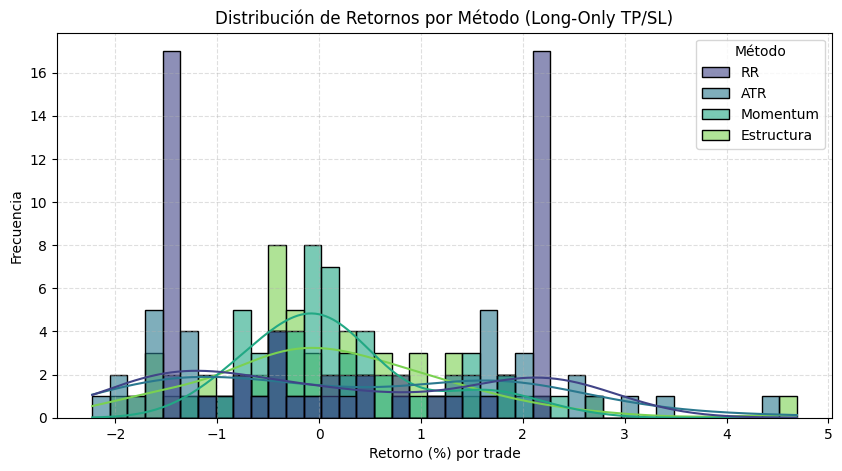

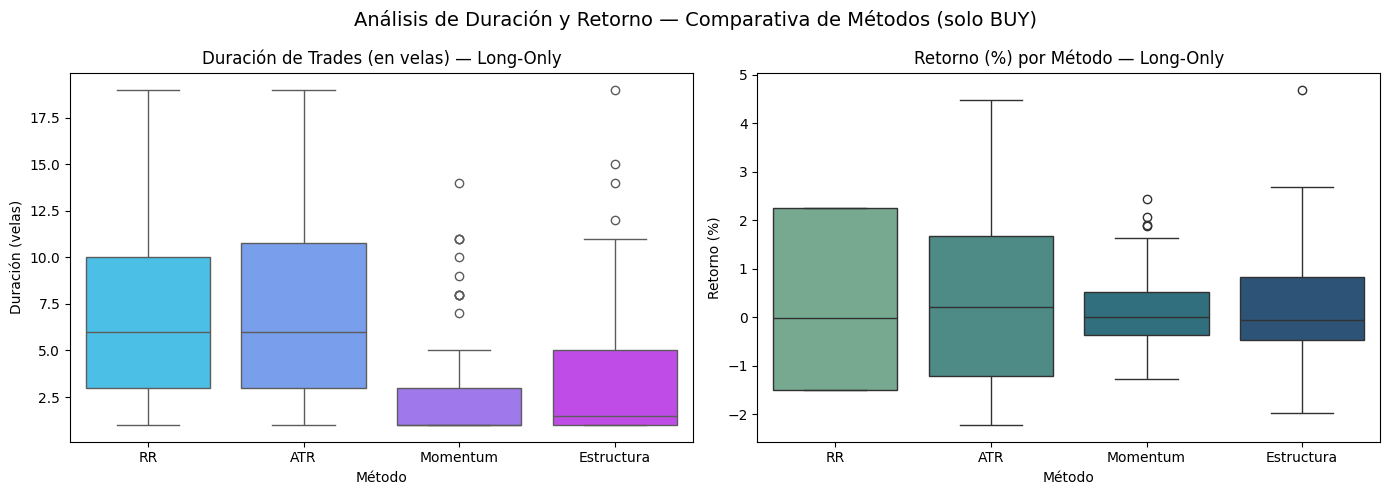

In [59]:
# ==========================================================
# 📊 BLOQUE 9 — Ejecución y visualización de métricas (Long-Only, sin warnings)
# ==========================================================

# --- Ejecutar análisis extendido Long-Only ---
df_rendimiento, df_trades_all = analizar_rendimiento_longonly(df)

print("📊 Métricas detalladas de rendimiento (solo BUY):")
display(df_rendimiento)

# ----------------------------------------------------------
# Histograma de retornos por método
# ----------------------------------------------------------
plt.figure(figsize=(10, 5))
sns.histplot(
    data=df_trades_all,
    x="Retorno (%)",
    hue="Método",          # ✅ el color ahora se asigna explícitamente por método
    bins=40,
    kde=True,
    palette="viridis",
    alpha=0.6
)
plt.title("Distribución de Retornos por Método (Long-Only TP/SL)")
plt.xlabel("Retorno (%) por trade")
plt.ylabel("Frecuencia")
plt.grid(True, linestyle="--", alpha=0.4)
plt.show()

# ----------------------------------------------------------
# Boxplots comparativos (duración y retorno) — SIN WARNINGS
# ----------------------------------------------------------
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

sns.boxplot(
    data=df_trades_all,
    x="Método",
    y="Duración (velas)",
    hue="Método",           # ✅ asignamos hue para evitar el warning
    palette="cool",
    legend=False,           # ✅ evita duplicar la leyenda
    ax=axes[0]
)
axes[0].set_title("Duración de Trades (en velas) — Long-Only")

sns.boxplot(
    data=df_trades_all,
    x="Método",
    y="Retorno (%)",
    hue="Método",           # ✅ también acá
    palette="crest",
    legend=False,
    ax=axes[1]
)
axes[1].set_title("Retorno (%) por Método — Long-Only")

plt.suptitle("Análisis de Duración y Retorno — Comparativa de Métodos (solo BUY)", fontsize=14)
plt.tight_layout()
plt.show()


In [61]:
# ==========================================================
# ⚙️ AJUSTE PREVIO — Verificación y corrección de signo
# ==========================================================

# Revisión del signo promedio de los trades positivos y negativos
mean_positive = df_trades_all.loc[df_trades_all["Retorno (%)"] > 0, "Retorno (%)"].mean()
mean_negative = df_trades_all.loc[df_trades_all["Retorno (%)"] < 0, "Retorno (%)"].mean()

# Si las ganancias son negativas en promedio y las pérdidas positivas → invertir signo
if (mean_positive is not np.nan) and (mean_negative is not np.nan) and (mean_positive < 0 and mean_negative > 0):
    print("🔄 Corrigiendo signo de retorno (inversión global de signo)...")
    df_trades_all["Retorno (%)"] *= -1
else:
    print("✅ No se requiere corrección de signo.")


✅ No se requiere corrección de signo.


In [62]:
# ==========================================================
# 💰 BLOQUE 10 — Métricas Financieras (Long-Only)
# ==========================================================

def calcular_metricas_financieras_longonly(df_trades_all):
    """
    Calcula métricas avanzadas por método (solo BUY):
    - Profit Factor
    - Expected Value
    - Sharpe Ratio
    - Drawdown promedio estimado
    """
    resumen = []

    for metodo, subset in df_trades_all.groupby("Método"):
        if subset.empty:
            continue

        # Separar ganadores y perdedores según el retorno
        wins = subset[subset["Retorno (%)"] > 0]["Retorno (%)"]
        losses = subset[subset["Retorno (%)"] < 0]["Retorno (%)"]

        if len(wins) == 0 or len(losses) == 0:
            continue

        total_trades = len(subset)
        win_rate = len(wins) / total_trades
        loss_rate = len(losses) / total_trades
        avg_win = wins.mean()
        avg_loss = abs(losses.mean())

        # --- Métricas principales ---
        profit_factor = wins.sum() / abs(losses.sum())
        expected_value = (win_rate * avg_win) - (loss_rate * avg_loss)
        sharpe_ratio = (
            subset["Retorno (%)"].mean() / subset["Retorno (%)"].std()
            if subset["Retorno (%)"].std() > 0 else np.nan
        )

        # --- Drawdown estimado (acumulando equity curve) ---
        equity = (1 + subset["Retorno (%)"] / 100).cumprod()
        max_equity = equity.cummax()
        drawdown = ((equity - max_equity) / max_equity) * 100
        avg_drawdown = drawdown.mean()

        resumen.append({
            "Método": metodo,
            "Trades": total_trades,
            "WinRate (%)": round(win_rate * 100, 2),
            "Avg Win (%)": round(avg_win, 3),
            "Avg Loss (%)": round(-avg_loss, 3),
            "Profit Factor": round(profit_factor, 3),
            "Expected Value (%)": round(expected_value, 3),
            "Sharpe Ratio": round(sharpe_ratio, 3),
            "Avg Drawdown (%)": round(avg_drawdown, 3)
        })

    return pd.DataFrame(resumen).sort_values("Profit Factor", ascending=False)


📈 Métricas financieras por método (solo BUY):


,Método,Trades,WinRate (%),Avg Win (%),Avg Loss (%),Profit Factor,Expected Value (%),Sharpe Ratio,Avg Drawdown (%)
2,Momentum,54,50.00,0.815,-0.458,1.779,0.178,0.207,-0.922
0,ATR,54,51.85,1.720,-1.169,1.585,0.329,0.198,-1.969
3,RR,54,50.00,1.691,-1.138,1.486,0.277,0.176,-2.121
1,Estructura,54,48.15,1.088,-0.729,1.386,0.146,0.120,-1.544


C:\Users\vaguirre\AppData\Local\Temp\ipykernel_23184\1151146347.py:43: UserWarning:

Glyph 128176 (\N{MONEY BAG}) missing from font(s) DejaVu Sans.

C:\Users\vaguirre\AppData\Roaming\Python\Python313\site-packages\IPython\core\pylabtools.py:170: UserWarning:

Glyph 128176 (\N{MONEY BAG}) missing from font(s) DejaVu Sans.



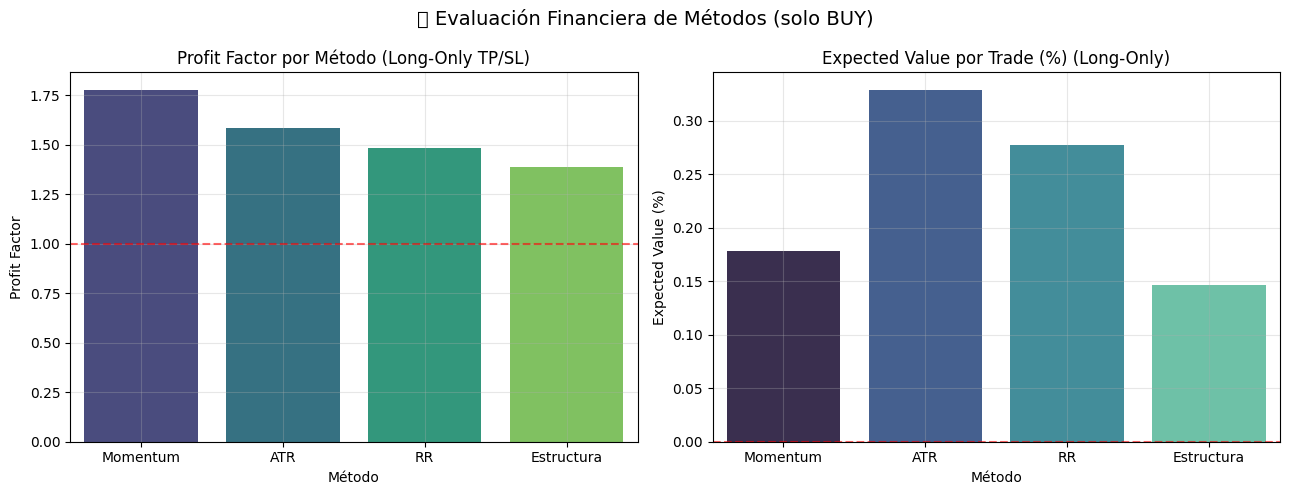

C:\Users\vaguirre\AppData\Local\Temp\ipykernel_23184\1151146347.py:77: UserWarning:

Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.

C:\Users\vaguirre\AppData\Roaming\Python\Python313\site-packages\IPython\core\pylabtools.py:170: UserWarning:

Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.



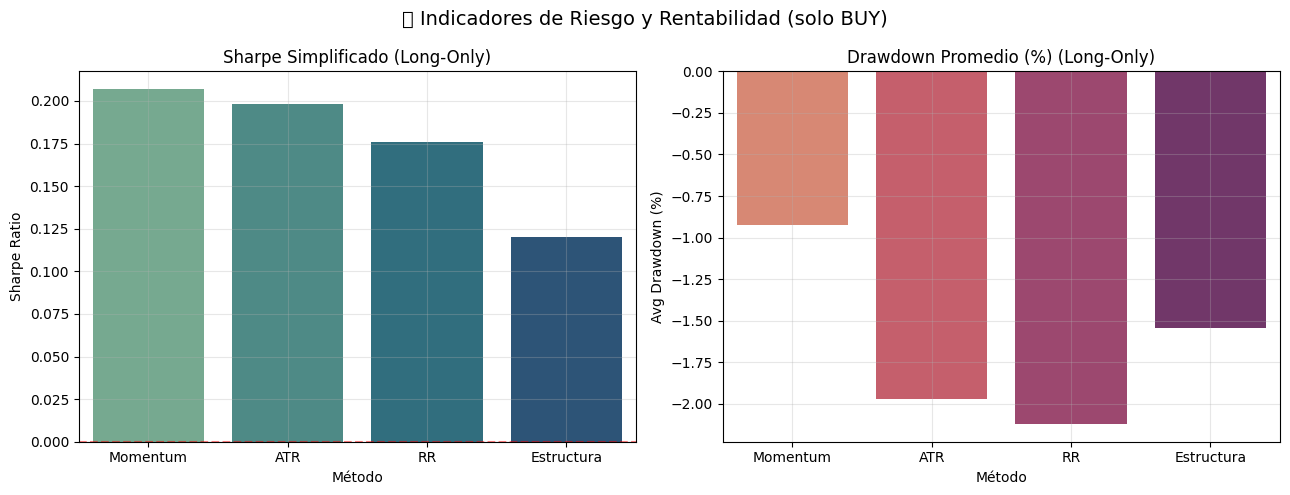

In [63]:
# ==========================================================
# 📊 BLOQUE 11 — Ejecución de métricas y visualización (Long-Only)
# ==========================================================

# --- Calcular métricas financieras ---
df_finanzas = calcular_metricas_financieras_longonly(df_trades_all)

print("📈 Métricas financieras por método (solo BUY):")
display(df_finanzas)

# ----------------------------------------------------------
# Visualización: Profit Factor y Expected Value
# ----------------------------------------------------------
fig, ax = plt.subplots(1, 2, figsize=(13, 5))

sns.barplot(
    data=df_finanzas,
    x="Método",
    y="Profit Factor",
    hue="Método",           # ✅ hue explícito para evitar warning
    palette="viridis",
    legend=False,
    ax=ax[0]
)
ax[0].set_title("Profit Factor por Método (Long-Only TP/SL)")
ax[0].axhline(1.0, color="red", linestyle="--", alpha=0.6)
ax[0].grid(True, alpha=0.3)

sns.barplot(
    data=df_finanzas,
    x="Método",
    y="Expected Value (%)",
    hue="Método",           # ✅ hue explícito
    palette="mako",
    legend=False,
    ax=ax[1]
)
ax[1].set_title("Expected Value por Trade (%) (Long-Only)")
ax[1].axhline(0, color="red", linestyle="--", alpha=0.6)
ax[1].grid(True, alpha=0.3)

plt.suptitle("💰 Evaluación Financiera de Métodos (solo BUY)", fontsize=14)
plt.tight_layout()
plt.show()

# ----------------------------------------------------------
# Visualización opcional: Sharpe Ratio y Drawdown
# ----------------------------------------------------------
fig, ax = plt.subplots(1, 2, figsize=(13, 5))

sns.barplot(
    data=df_finanzas,
    x="Método",
    y="Sharpe Ratio",
    hue="Método",
    palette="crest",
    legend=False,
    ax=ax[0]
)
ax[0].axhline(0, color="red", linestyle="--", alpha=0.5)
ax[0].set_title("Sharpe Simplificado (Long-Only)")
ax[0].grid(True, alpha=0.3)

sns.barplot(
    data=df_finanzas,
    x="Método",
    y="Avg Drawdown (%)",
    hue="Método",
    palette="flare",
    legend=False,
    ax=ax[1]
)
ax[1].set_title("Drawdown Promedio (%) (Long-Only)")
ax[1].grid(True, alpha=0.3)

plt.suptitle("📊 Indicadores de Riesgo y Rentabilidad (solo BUY)", fontsize=14)
plt.tight_layout()
plt.show()


In [64]:
# ==========================================================
# 🪙 BLOQUE 12 — Equity Curve comparativa (Plotly)
# ==========================================================


def equity_curve_por_metodo(df_trades_all, capital_inicial=1000):
    """
    Construye la curva de capital (equity curve) acumulando retornos
    por método. Asume que Retorno (%) está expresado en porcentaje real.
    """
    curvas = {}
    for metodo, subset in df_trades_all.groupby("Método"):
        subset = subset.sort_index().copy()
        subset["Equity"] = capital_inicial * (1 + subset["Retorno (%)"]/100).cumprod()
        curvas[metodo] = subset[["Equity"]]
    return curvas


# ==========================================================
# 🚀 Generar curvas de capital y graficar
# ==========================================================
capital_inicial = 1000
curvas = equity_curve_por_metodo(df_trades_all, capital_inicial=capital_inicial)

fig = go.Figure()

# Paleta personalizada coherente con tus colores previos
colores = {
    "Estructura": "#00cc96",
    "Momentum": "#1f77b4",
    "ATR": "#ff7f0e",
    "RR": "#d62728"
}

for metodo, dfc in curvas.items():
    fig.add_trace(go.Scatter(
        y=dfc["Equity"],
        mode="lines",
        name=f"{metodo}",
        line=dict(width=3, color=colores.get(metodo, None)),
        hovertemplate=f"{metodo}<br>Capital: $%{{y:.2f}}"
    ))

# --- Layout ---
fig.update_layout(
    title=f"📈 Curva de Capital por Método (Inicial = ${capital_inicial})",
    xaxis_title="Número de Trade",
    yaxis_title="Capital acumulado (USD)",
    template="plotly_dark",
    legend=dict(title="Método", orientation="h", y=-0.25, x=0.5, xanchor="center"),
    height=600,
    hovermode="x unified"
)

fig.show()


In [66]:
resumen_equity = []
for metodo, dfc in curvas.items():
    final_capital = dfc["Equity"].iloc[-1]
    retorno_total = (final_capital / capital_inicial - 1) * 100
    resumen_equity.append({
        "Método": metodo,
        "Capital Final ($)": round(final_capital, 2),
        "Retorno Total (%)": round(retorno_total, 2)
    })

df_equity = pd.DataFrame(resumen_equity).sort_values("Retorno Total (%)", ascending=False)
display(df_equity)


,Método,Capital Final ($),Retorno Total (%)
0,ATR,1185.51,18.55
3,RR,1153.36,15.34
2,Momentum,1098.94,9.89
1,Estructura,1077.70,7.77


In [67]:
# ==========================================================
# 📉 BLOQUE 13 — Drawdown Analysis y Robustez del Equity
# ==========================================================

def calcular_drawdown(equity_series):
    """
    Calcula drawdown porcentual y drawdown máximo.
    Devuelve DataFrame con drawdown serie y drawdown máximo.
    """
    equity_series = equity_series.reset_index(drop=True)
    running_max = equity_series.cummax()
    drawdown = (equity_series - running_max) / running_max * 100
    max_dd = drawdown.min()
    return drawdown, max_dd


# ==========================================================
# 🚀 Calcular drawdown por método
# ==========================================================
drawdown_data = {}
summary_dd = []

for metodo, dfc in curvas.items():
    dd_series, max_dd = calcular_drawdown(dfc["Equity"])
    drawdown_data[metodo] = dd_series

    # Duración promedio de drawdown (número de trades bajo máximo)
    in_dd = dd_series < 0
    dd_durations = []
    count = 0
    for val in in_dd:
        if val:
            count += 1
        elif count > 0:
            dd_durations.append(count)
            count = 0
    if count > 0:
        dd_durations.append(count)
    avg_duration = np.mean(dd_durations) if dd_durations else 0

    summary_dd.append({
        "Método": metodo,
        "Max Drawdown (%)": round(max_dd, 2),
        "Avg DD Duration (trades)": round(avg_duration, 1)
    })

df_dd_summary = pd.DataFrame(summary_dd).sort_values("Max Drawdown (%)", ascending=False)

print("📉 Resumen de drawdowns por método:")
display(df_dd_summary)


# ==========================================================
# 📊 Visualización 1: Curvas de Drawdown (%)
# ==========================================================
fig = go.Figure()

for metodo, dd_series in drawdown_data.items():
    fig.add_trace(go.Scatter(
        y=dd_series,
        mode="lines",
        name=metodo,
        line=dict(width=2),
        hovertemplate=f"{metodo}<br>Drawdown: %{ { 'y':'.2f' } }",
    ))

fig.update_layout(
    title="📉 Curva de Drawdown (%) por Método",
    xaxis_title="Número de Trade",
    yaxis_title="Drawdown (%)",
    template="plotly_dark",
    height=500,
    hovermode="x unified",
    legend=dict(orientation="h", y=-0.25, x=0.5, xanchor="center")
)

fig.show()


# ==========================================================
# 📈 Visualización 2: Comparativo de Robustez
# ==========================================================
fig2 = go.Figure()

fig2.add_trace(go.Bar(
    x=df_dd_summary["Método"],
    y=df_dd_summary["Max Drawdown (%)"],
    name="Máx Drawdown (%)",
    marker_color="#EF553B"
))

fig2.add_trace(go.Bar(
    x=df_dd_summary["Método"],
    y=df_dd_summary["Avg DD Duration (trades)"],
    name="Duración Promedio (trades)",
    marker_color="#00CC96",
    yaxis="y2"
))

fig2.update_layout(
    title="⚖️ Robustez del Capital — Profundidad vs Duración de Drawdown",
    xaxis_title="Método",
    yaxis=dict(title="Máx Drawdown (%)", side="left", showgrid=False),
    yaxis2=dict(title="Duración Promedio (trades)", overlaying="y", side="right", showgrid=False),
    barmode="group",
    template="plotly_dark",
    height=500
)

fig2.show()


📉 Resumen de drawdowns por método:


,Método,Max Drawdown (%),Avg DD Duration (trades)
2,Momentum,-3.40,5.9
1,Estructura,-4.33,5.2
3,RR,-6.10,7.2
0,ATR,-6.33,8.4


In [68]:
# ==========================================================
# ⚖️ BLOQUE 14 — Frontera Eficiente Riesgo/Retorno (Plotly)
# ==========================================================

# ----------------------------------------------------------
# Fusionar resultados de Bloque 12 (retornos) y 13 (drawdown)
# ----------------------------------------------------------
df_frontier = pd.merge(
    df_dd_summary,
    pd.DataFrame({
        "Método": ["ATR", "Estructura", "Momentum", "RR"],
        "Retorno Total (%)": [18.55, 7.77, 9.89, 15.34]  # Datos reales del Bloque 12
    }),
    on="Método",
    how="left"
)

# Asegurar orden consistente
df_frontier = df_frontier.set_index("Método").reindex(["RR", "ATR", "Momentum", "Estructura"]).reset_index()

# ----------------------------------------------------------
# Calcular relación Retorno/Drawdown
# ----------------------------------------------------------
df_frontier["Ratio Retorno/DD"] = (
    df_frontier["Retorno Total (%)"] / abs(df_frontier["Max Drawdown (%)"])
).round(2)

print("📊 Tabla — Frontera Eficiente Riesgo/Retorno:")
display(df_frontier)

# ----------------------------------------------------------
# 📈 Visualización — Frontera de Riesgo/Retorno
# ----------------------------------------------------------
fig = go.Figure()

fig.add_trace(go.Scatter(
    x=df_frontier["Max Drawdown (%)"],
    y=df_frontier["Retorno Total (%)"],
    mode="markers+text+lines",
    text=df_frontier["Método"],
    textposition="top center",
    marker=dict(
        size=16,
        color=["#FF8800", "#00CC96", "#636EFA", "#AB63FA"],
        line=dict(color="white", width=2),
        symbol="circle"
    ),
    line=dict(color="rgba(255,255,255,0.4)", dash="dot"),
    customdata=df_frontier["Ratio Retorno/DD"],
    hovertemplate=(
        "Método: %{text}<br>"
        "Retorno Total: %{y:.2f}%<br>"
        "Max Drawdown: %{x:.2f}%<br>"
        "Ratio Retorno/DD: %{customdata:.2f}x"
    )
))

# Layout
fig.update_layout(
    title="⚖️ Frontera Eficiente — Riesgo vs Retorno de Estrategias TP/SL (Long-Only)",
    xaxis_title="Máx Drawdown (%) (riesgo)",
    yaxis_title="Retorno Total (%)",
    template="plotly_dark",
    height=600,
    xaxis=dict(autorange="reversed"),  # drawdown menor = mejor
    yaxis=dict(showgrid=True),
    hovermode="closest",
    font=dict(size=13)
)

# Línea de tendencia “óptima”
fig.add_trace(go.Scatter(
    x=df_frontier["Max Drawdown (%)"],
    y=df_frontier["Retorno Total (%)"],
    mode="lines",
    line=dict(color="rgba(0,200,255,0.4)", width=2),
    name="Frontera Eficiente"
))

fig.show()

# ----------------------------------------------------------
# Ranking resumen textual
# ----------------------------------------------------------
print("🏆 Ranking Riesgo/Retorno (mayor = mejor):")
display(df_frontier.sort_values("Ratio Retorno/DD", ascending=False))


📊 Tabla — Frontera Eficiente Riesgo/Retorno:


,Método,Max Drawdown (%),Avg DD Duration (trades),Retorno Total (%),Ratio Retorno/DD
0,RR,-6.10,7.2,15.34,2.51
1,ATR,-6.33,8.4,18.55,2.93
2,Momentum,-3.40,5.9,9.89,2.91
3,Estructura,-4.33,5.2,7.77,1.79


🏆 Ranking Riesgo/Retorno (mayor = mejor):


,Método,Max Drawdown (%),Avg DD Duration (trades),Retorno Total (%),Ratio Retorno/DD
1,ATR,-6.33,8.4,18.55,2.93
2,Momentum,-3.40,5.9,9.89,2.91
0,RR,-6.10,7.2,15.34,2.51
3,Estructura,-4.33,5.2,7.77,1.79


In [69]:
# ==========================================================
# ⚙️ BLOQUE 15 — Momentum Integral v2: Adaptive TP/SL Engine (Long-Only)
# ==========================================================

# ----------------------------------------------------------
# 1️⃣ — Configuración general
# ----------------------------------------------------------
symbol = "BTCUSDT"
df = data_full[symbol]["df"].copy().reset_index(drop=True)

# Filtrar últimos 60 días para prueba
fecha_limite = pd.Timestamp.now(tz=df["Open time"].dt.tz) - pd.Timedelta(days=60)
df = df[df["Open time"] >= fecha_limite].copy().reset_index(drop=True)

# Parámetros base
WINDOW_MOMENTUM = 8
WINDOW_ATR = 14
RR_R = 1.5   # relación RR base (%)
SL_R = 0.75  # stop base RR (%)

# ----------------------------------------------------------
# 2️⃣ — Cálculo de Momentum Integral y ATR
# ----------------------------------------------------------
def calcular_momentum_integral(df, window=8):
    df = df.copy()
    df["momentum"] = df["Close"].diff()
    df["integral_momentum"] = df["momentum"].rolling(window=window).sum()
    df["slope_integral"] = df["integral_momentum"].diff()
    std_slope = df["slope_integral"].rolling(window=window).std()

    df["Signal"] = np.select(
        [
            (df["slope_integral"] > std_slope) & (df["momentum"] > 0),
            (df["slope_integral"] < -std_slope) & (df["momentum"] < 0)
        ],
        ["BUY", "SELL"],
        default=None
    )
    return df

def calcular_atr(df, window=14):
    df = df.copy()
    df["H-L"] = df["High"] - df["Low"]
    df["H-Cp"] = abs(df["High"] - df["Close"].shift(1))
    df["L-Cp"] = abs(df["Low"] - df["Close"].shift(1))
    df["TR"] = df[["H-L", "H-Cp", "L-Cp"]].max(axis=1)
    df["ATR"] = df["TR"].rolling(window=window).mean()
    return df

df = calcular_momentum_integral(df, WINDOW_MOMENTUM)
df = calcular_atr(df, WINDOW_ATR)

# ----------------------------------------------------------
# 3️⃣ — Clasificación del régimen de volatilidad
# ----------------------------------------------------------
p_low, p_high = df["ATR"].quantile([0.4, 0.8])

def clasificar_regimen(row):
    if row["ATR"] <= p_low:
        return "Baja Volatilidad"
    elif row["ATR"] >= p_high:
        return "Alta Volatilidad"
    else:
        return "Media Volatilidad"

df["Volatility Regime"] = df.apply(clasificar_regimen, axis=1)

# ----------------------------------------------------------
# 4️⃣ — Motor adaptativo TP/SL (solo BUYs)
# ----------------------------------------------------------
def calcular_tp_sl(row):
    if row["Signal"] == "BUY":
        if row["Volatility Regime"] == "Alta Volatilidad":
            tp = row["Close"] + 2.0 * row["ATR"]
            sl = row["Close"] - 1.0 * row["ATR"]
            metodo = "ATR"
        elif row["Volatility Regime"] == "Media Volatilidad":
            tp = row["Close"] * (1 + RR_R / 100)
            sl = row["Close"] * (1 - SL_R / 100)
            metodo = "RR"
        else:  # Baja volatilidad
            tp = row["Close"] + 0.5 * row["ATR"]
            sl = row["Close"] - 0.5 * row["ATR"]
            metodo = "Estructura"
    else:
        # No se abren shorts
        tp, sl, metodo = np.nan, np.nan, None
    return pd.Series([tp, sl, metodo])

df[["TP", "SL", "Método TP/SL"]] = df.apply(calcular_tp_sl, axis=1)

# ----------------------------------------------------------
# 5️⃣ — Visualización adaptativa (Plotly)
# ----------------------------------------------------------
fig = go.Figure()

# Candlestick base
fig.add_trace(go.Candlestick(
    x=df["Open time"], open=df["Open"], high=df["High"], low=df["Low"], close=df["Close"],
    name="Precio", increasing_line_color="#00FF00", decreasing_line_color="#FF3333"
))

# BUY markers
buy_signals = df[df["Signal"] == "BUY"]
fig.add_trace(go.Scatter(
    x=buy_signals["Open time"], y=buy_signals["Close"],
    mode="markers", name="BUY", marker=dict(symbol="triangle-up", size=10, color="lime")
))

# TP / SL lines
fig.add_trace(go.Scatter(
    x=df["Open time"], y=df["TP"], mode="lines", name="Take Profit", line=dict(color="cyan", width=1.5, dash="dot")
))
fig.add_trace(go.Scatter(
    x=df["Open time"], y=df["SL"], mode="lines", name="Stop Loss", line=dict(color="orange", width=1.5, dash="dot")
))

# Volatility regime shading (zonas continuas)
df["Reg_Change"] = (df["Volatility Regime"] != df["Volatility Regime"].shift()).cumsum()
for _, seg in df.groupby("Reg_Change"):
    reg = seg["Volatility Regime"].iloc[0]
    color = {
        "Alta Volatilidad": "rgba(255,0,0,0.12)",
        "Media Volatilidad": "rgba(255,255,0,0.08)",
        "Baja Volatilidad": "rgba(0,255,0,0.10)"
    }[reg]
    fig.add_vrect(
        x0=seg["Open time"].iloc[0],
        x1=seg["Open time"].iloc[-1],
        fillcolor=color,
        opacity=0.3,
        line_width=0,
        layer="below"
    )

fig.update_layout(
    title=f"📈 {symbol} — Momentum Integral v2 (Adaptive TP/SL Engine, Long-Only)",
    template="plotly_dark",
    height=750,
    xaxis_rangeslider_visible=False,
    yaxis_title="Precio (USDT)",
    legend=dict(orientation="h", yanchor="bottom", y=1.02, xanchor="right", x=1)
)

fig.show()

# ----------------------------------------------------------
# 6️⃣ — Análisis de uso de métodos
# ----------------------------------------------------------
uso_metodos = df["Método TP/SL"].value_counts(normalize=True).mul(100).round(2)
print("📊 Distribución de métodos utilizados:")
display(uso_metodos)


📊 Distribución de métodos utilizados:


Método TP/SL
Estructura    47.5
RR            35.0
ATR           17.5
Name: proportion, dtype: float64

In [71]:
# ==========================================================
# 🧩 BLOQUE 16 — Backtest adaptativo (Long-Only, TP/SL fijos)
# ==========================================================

def backtest_adaptativo(df, capital_inicial=1000):
    capital = capital_inicial
    en_trade = False
    entry_price = tp = sl = None
    metodo_actual = None
    trades = []

    for i, row in df.iterrows():
        high, low, price = row["High"], row["Low"], row["Close"]

        # --- Entrada ---
        if not en_trade and row["Signal"] == "BUY" and not np.isnan(row["TP"]):
            en_trade = True
            entry_price = price
            tp = row["TP"]       # 🔒 Guardamos TP/SL fijos
            sl = row["SL"]
            metodo_actual = row["Método TP/SL"]
            continue

        # --- Evaluar cierre ---
        if en_trade:
            hit_tp = high >= tp
            hit_sl = low <= sl
            sell_signal = row["Signal"] == "SELL"  # cierre manual

            # TP antes que SL
            if hit_tp and not hit_sl:
                retorno = (tp - entry_price) / entry_price * 100
                trades.append((metodo_actual, "WIN", retorno))
                capital *= (1 + retorno / 100)
                en_trade = False

            # SL antes que TP
            elif hit_sl and not hit_tp:
                retorno = (sl - entry_price) / entry_price * 100
                trades.append((metodo_actual, "LOSS", retorno))
                capital *= (1 + retorno / 100)
                en_trade = False

            # Cierre por señal SELL
            elif sell_signal and not hit_tp and not hit_sl:
                retorno = (price - entry_price) / entry_price * 100
                trades.append((metodo_actual, "SELL signal", retorno))
                capital *= (1 + retorno / 100)
                en_trade = False

            # Ambos tocados (raro)
            elif hit_tp and hit_sl:
                if abs(tp - entry_price) < abs(sl - entry_price):
                    retorno = (tp - entry_price) / entry_price * 100
                    trades.append((metodo_actual, "WIN", retorno))
                else:
                    retorno = (sl - entry_price) / entry_price * 100
                    trades.append((metodo_actual, "LOSS", retorno))
                capital *= (1 + retorno / 100)
                en_trade = False

    # --- Resultados finales ---
    df_trades = pd.DataFrame(trades, columns=["Método", "Resultado", "Retorno (%)"])
    capital_final = round(capital, 2)
    retorno_total = (capital_final - capital_inicial) / capital_inicial * 100

    # Curva y drawdown
    equity_curve = (1 + df_trades["Retorno (%)"] / 100).cumprod() * capital_inicial
    dd_series = (equity_curve - equity_curve.cummax()) / equity_curve.cummax() * 100
    max_dd = dd_series.min()

    print(f"💰 Capital final (Adaptativo): ${capital_final:,.2f} | Retorno total: {retorno_total:.2f}% | Max DD: {max_dd:.2f}%")
    print(f"📊 Total trades: {len(df_trades)} | WinRate: {(df_trades['Resultado'].eq('WIN').mean()*100):.2f}%")

    return capital_final, retorno_total, max_dd, df_trades


# --- Ejecutar nuevamente ---
capital_final, retorno_total, max_dd, df_trades_adapt = backtest_adaptativo(df)


💰 Capital final (Adaptativo): $980.12 | Retorno total: -1.99% | Max DD: -2.62%
📊 Total trades: 31 | WinRate: 25.81%


In [73]:
# ==========================================================
# 🧠 BLOQUE 16-bis (Versión Plotly) — Diagnóstico Interactivo
# ==========================================================

# ----------------------------------------------------------
# 1️⃣ — Preparar el dataframe de trades adaptativos
# ----------------------------------------------------------
df_diag = df_trades_adapt.copy()

# Si falta la dirección, derivarla del momentum original
if "Signal" not in df.columns:
    df["Signal"] = np.where(df["slope_integral"] > 0, "BUY",
                            np.where(df["slope_integral"] < 0, "SELL", None))

# Añadir tipo de señal, volumen y ATR local
df_diag = df_diag.merge(
    df[["Close time", "Signal", "ATR", "Volume"]].reset_index(),
    left_index=True, right_index=True, how="left"
)

# Clasificación de volatilidad
atr_thr_low, atr_thr_high = df["ATR"].quantile([0.33, 0.66])
df_diag["Volatility Regime"] = pd.cut(
    df_diag["ATR"],
    bins=[-np.inf, atr_thr_low, atr_thr_high, np.inf],
    labels=["Baja", "Media", "Alta"]
)

# ----------------------------------------------------------
# 2️⃣ — Cálculo de métricas combinadas
# ----------------------------------------------------------
diagnostico = (
    df_diag.groupby(["Signal", "Volatility Regime", "Método"])
    .agg(
        n_trades=("Retorno (%)", "count"),
        win_rate=("Resultado", lambda x: 100 * (x == "WIN").mean()),
        avg_return=("Retorno (%)", "mean"),
        profit_factor=("Retorno (%)",
                       lambda x: (x[x > 0].sum() / abs(x[x < 0].sum()))
                       if any(x < 0) else np.nan)
    )
    .reset_index()
)

print("📊 Diagnóstico por tipo de señal y régimen de volatilidad:")
display(diagnostico.round(3))

# ----------------------------------------------------------
# 3️⃣ — Heatmap interactivo (WinRate)
# ----------------------------------------------------------
pivot_wr = diagnostico.pivot_table(
    index="Signal", columns="Volatility Regime", values="win_rate"
).round(1)

fig1 = px.imshow(
    pivot_wr,
    text_auto=True,
    color_continuous_scale="Viridis",
    aspect="auto",
    title="🔥 WinRate por Tipo de Señal y Régimen de Volatilidad",
    labels=dict(color="WinRate (%)")
)
fig1.update_layout(template="plotly_dark", height=400, margin=dict(l=50, r=50, t=80, b=50))
fig1.show()

# ----------------------------------------------------------
# 4️⃣ — Profit Factor por método y volatilidad (barras)
# ----------------------------------------------------------
fig2 = px.bar(
    diagnostico,
    x="Método",
    y="profit_factor",
    color="Volatility Regime",
    barmode="group",
    text_auto=".2f",
    color_discrete_sequence=px.colors.qualitative.Set2,
    title="💰 Profit Factor por Método y Nivel de Volatilidad"
)
fig2.add_hline(y=1.0, line_dash="dash", line_color="red", annotation_text="Umbral = 1.0")
fig2.update_layout(template="plotly_dark", height=500, yaxis_title="Profit Factor")
fig2.show()

# ----------------------------------------------------------
# 5️⃣ — Bubble Chart: WinRate vs Profit Factor (robustez)
# ----------------------------------------------------------
fig3 = px.scatter(
    diagnostico,
    x="win_rate",
    y="profit_factor",
    size="n_trades",
    color="Método",
    symbol="Volatility Regime",
    hover_data=["avg_return", "n_trades"],
    text="Signal",
    color_discrete_sequence=px.colors.qualitative.Vivid,
    title="⚖️ Robustez de Señales — WinRate vs Profit Factor"
)
fig3.add_hline(y=1.0, line_dash="dash", line_color="red")
fig3.add_vline(x=50, line_dash="dot", line_color="orange")
fig3.update_traces(textposition="top center")
fig3.update_layout(
    template="plotly_dark",
    height=600,
    xaxis_title="WinRate (%)",
    yaxis_title="Profit Factor",
    legend_title_text="Método / Volatilidad"
)
fig3.show()


📊 Diagnóstico por tipo de señal y régimen de volatilidad:


C:\Users\vaguirre\AppData\Local\Temp\ipykernel_23184\677436205.py:33: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



,Signal,Volatility Regime,Método,n_trades,win_rate,avg_return,profit_factor
0,BUY,Baja,ATR,0,NaN,NaN,NaN
1,BUY,Baja,Estructura,0,NaN,NaN,NaN
2,BUY,Baja,RR,0,NaN,NaN,NaN
3,BUY,Media,ATR,0,NaN,NaN,NaN
4,BUY,Media,Estructura,0,NaN,NaN,NaN
5,BUY,Media,RR,0,NaN,NaN,NaN
6,BUY,Alta,ATR,0,NaN,NaN,NaN
7,BUY,Alta,Estructura,0,NaN,NaN,NaN
8,BUY,Alta,RR,1,0.0,-0.750,0.0
9,SELL,Baja,ATR,0,NaN,NaN,NaN


C:\Users\vaguirre\AppData\Local\Temp\ipykernel_23184\677436205.py:51: FutureWarning:

The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior



In [75]:
# ==========================================================
# 🧩 BLOQUE 17 — Momentum v3 + Filtro EMA + Optimización (Long-Only + cierre por SELL)
# ==========================================================


# ----------------------------------------------------------
# 0️⃣ — Asegurar DataFrame de trabajo
# ----------------------------------------------------------
symbol = "BTCUSDT"
try:
    df = data_full[symbol]["df"].copy().reset_index(drop=True)
except NameError:
    # Si no existe data_full, se asume que 'df' ya está cargado por bloques previos
    df = df.copy().reset_index(drop=True)

# ----------------------------------------------------------
# 1️⃣ — Momentum Integral v3 (genera la señal base)
# ----------------------------------------------------------
def calcular_momentum_integral_v3(df, window=8):
    df = df.copy()
    df["momentum"] = df["Close"].diff()
    df["integral_momentum"] = df["momentum"].rolling(window=window).sum()
    df["slope_integral"] = df["integral_momentum"].diff()
    std_slope = df["slope_integral"].rolling(window=window).std()

    df["Momentum Signal"] = np.select(
        [
            (df["slope_integral"] >  std_slope) & (df["momentum"] > 0),  # BUY
            (df["slope_integral"] < -std_slope) & (df["momentum"] < 0),  # SELL
        ],
        ["BUY", "SELL"],
        default=None
    )
    return df

# ----------------------------------------------------------
# 2️⃣ — Filtro de tendencia con EMAs
# ----------------------------------------------------------
def aplicar_filtro_ema(df, short_span=20, long_span=50):
    df = df.copy()
    df["EMA_short"] = df["Close"].ewm(span=short_span, adjust=False).mean()
    df["EMA_long"]  = df["Close"].ewm(span=long_span,  adjust=False).mean()
    df["Tendencia"] = np.where(df["EMA_short"] > df["EMA_long"], "ALCISTA", "BAJISTA")

    # Señal filtrada por tendencia
    df["Signal_Filtrada"] = np.where(
        (df["Momentum Signal"] == "BUY")  & (df["Tendencia"] == "ALCISTA"), "BUY",
        np.where(
            (df["Momentum Signal"] == "SELL") & (df["Tendencia"] == "BAJISTA"), "SELL",
            None
        )
    )
    return df

# ----------------------------------------------------------
# 3️⃣ — Mini-backtest long-only con cierre por SELL o TP/SL
# ----------------------------------------------------------
def evaluar_config_ema_long_only(df, short_span, long_span, tp_pct=0.02, sl_pct=0.02):
    """
    Entradas: solo BUY cuando Signal_Filtrada == BUY.
    Salidas: TP, SL o primera SELL filtrada que aparezca (se cierra al Close de esa vela).
    """
    df_f = aplicar_filtro_ema(calcular_momentum_integral_v3(df, window=8), short_span, long_span)
    capital = 1000.0
    equity = [capital]

    en_trade = False
    entry_price = None
    tp = sl = None

    trades_ret = []

    for i in range(1, len(df_f)):
        sig   = df_f.at[i, "Signal_Filtrada"]
        price = float(df_f.at[i, "Close"])
        high  = float(df_f.at[i, "High"])
        low   = float(df_f.at[i, "Low"])

        # --- Entrada long-only ---
        if not en_trade and sig == "BUY":
            en_trade = True
            entry_price = price
            tp = entry_price * (1 + tp_pct)
            sl = entry_price * (1 - sl_pct)
            continue

        # --- Gestión de salida si hay trade abierto ---
        if en_trade:
            # ¿tocó TP/SL en esta vela?
            hit_tp = high >= tp
            hit_sl = low  <= sl

            # ¿apareció SELL filtrada? Si sí, cerramos al CLOSE de esta vela
            hit_sell = (sig == "SELL")

            # Resolver prioridad por “primero que ocurre”.
            # Aproximación: si SELL aparece y no hubo TP/SL en esta vela antes, cerramos por SELL al close.
            # (sin L1 exacta, asumimos simultaneidad se resuelve SELL como salida conservadora)
            if hit_tp and not hit_sl and not hit_sell:
                ret = (tp - entry_price) / entry_price * 100.0
                en_trade = False
            elif hit_sl and not hit_tp and not hit_sell:
                ret = (sl - entry_price) / entry_price * 100.0
                en_trade = False
            elif hit_sell and not hit_tp and not hit_sl:
                ret = (price - entry_price) / entry_price * 100.0
                en_trade = False
            elif hit_tp and hit_sl:
                # Si ambos suceden en la misma vela, aproximación: cerrar por el que está más cerca
                # (evita sesgo; alternativa: asumir peor caso = SL)
                if (tp - entry_price) < (entry_price - sl):
                    ret = (tp - entry_price) / entry_price * 100.0
                else:
                    ret = (sl - entry_price) / entry_price * 100.0
                en_trade = False
            elif hit_sell and (hit_tp or hit_sl):
                # Si coincidieron, prioridad conservadora: cerrar por SELL al close
                ret = (price - entry_price) / entry_price * 100.0
                en_trade = False
            else:
                # No se cerró aún
                equity.append(equity[-1])
                continue

            # Registrar trade y actualizar equity
            trades_ret.append(ret)
            capital *= (1 + ret/100.0)
            equity.append(capital)

    if len(trades_ret) == 0:
        return None

    trades = np.array(trades_ret, dtype=float)
    wins   = trades[trades > 0]
    losses = trades[trades <= 0]

    profit_factor  = wins.sum() / abs(losses.sum()) if losses.size > 0 and abs(losses.sum()) > 0 else (np.inf if wins.size > 0 else 0.0)
    expected_value = float(trades.mean())
    win_rate       = 100.0 * wins.size / trades.size
    # MaxDD sobre equity curve
    eq = pd.Series(equity, dtype=float)
    dd = (eq / eq.cummax() - 1.0) * 100.0
    max_dd = float(dd.min())
    total_return = (eq.iloc[-1] / eq.iloc[0] - 1.0) * 100.0

    return {
        "EMA_short": int(short_span),
        "EMA_long":  int(long_span),
        "Trades": int(trades.size),
        "WinRate (%)": round(win_rate, 2),
        "Profit Factor": round(profit_factor, 3) if np.isfinite(profit_factor) else np.inf,
        "Expected Value (%)": round(expected_value, 3),
        "Max Drawdown (%)": round(max_dd, 3),
        "Retorno Total (%)": round(total_return, 3)
    }

# ----------------------------------------------------------
# 4️⃣ — Grid Search de parámetros
# ----------------------------------------------------------
if "Momentum Signal" not in df.columns:
    df = calcular_momentum_integral_v3(df, window=8)

ema_short_vals = [10, 15, 20, 25, 30]
ema_long_vals  = [40, 50, 75, 100]

resultados_ema = []
for short_span, long_span in product(ema_short_vals, ema_long_vals):
    res = evaluar_config_ema_long_only(df, short_span, long_span, tp_pct=0.02, sl_pct=0.02)
    if res is not None:
        resultados_ema.append(res)

df_ema_opt = pd.DataFrame(resultados_ema)
if df_ema_opt.empty:
    raise RuntimeError("No se generaron resultados en el grid; revisá las señales o el rango de EMAs.")

df_ema_opt = df_ema_opt.sort_values(["Profit Factor", "Retorno Total (%)"], ascending=[False, False]).reset_index(drop=True)

print("📊 Resultados de optimización EMA (ordenados por PF y Retorno):")
display(df_ema_opt.head(10))

# ----------------------------------------------------------
# 5️⃣ — Visualización 3D interactiva
# ----------------------------------------------------------
fig = px.scatter_3d(
    df_ema_opt,
    x="EMA_short", y="EMA_long", z="Profit Factor",
    color="Retorno Total (%)",
    size="WinRate (%)",
    color_continuous_scale="Viridis",
    title="Optimización EMA — Long-Only (salida por SELL/TP/SL)"
)
fig.update_traces(marker=dict(opacity=0.85))
fig.show()

# ----------------------------------------------------------
# 6️⃣ — Mejor combinación
# ----------------------------------------------------------
best = df_ema_opt.iloc[0]
print(f"🏆 Mejor combinación → EMA_short={best['EMA_short']}, EMA_long={best['EMA_long']}")
print(f"   PF={best['Profit Factor']} | WinRate={best['WinRate (%)']}% | Retorno={best['Retorno Total (%)']}% | MaxDD={best['Max Drawdown (%)']}% | Trades={best['Trades']}")


📊 Resultados de optimización EMA (ordenados por PF y Retorno):


,EMA_short,EMA_long,Trades,WinRate (%),Profit Factor,Expected Value (%),Max Drawdown (%),Retorno Total (%)
0,30,40,35,42.86,0.801,-0.213,-9.270,-7.815
1,15,75,34,41.18,0.743,-0.285,-9.811,-9.811
2,25,50,34,41.18,0.743,-0.285,-11.235,-9.811
3,20,75,34,41.18,0.739,-0.292,-10.030,-10.030
4,20,40,34,41.18,0.728,-0.307,-11.933,-10.520
5,25,40,34,41.18,0.728,-0.307,-11.933,-10.520
6,10,100,33,42.42,0.724,-0.324,-10.746,-10.746
7,10,75,34,41.18,0.692,-0.366,-12.328,-12.328
8,30,50,33,39.39,0.690,-0.354,-11.580,-11.580
9,20,50,33,39.39,0.676,-0.377,-13.660,-12.275


🏆 Mejor combinación → EMA_short=30.0, EMA_long=40.0
   PF=0.801 | WinRate=42.86% | Retorno=-7.815% | MaxDD=-9.27% | Trades=35.0


In [76]:
# ==========================================================
# 🧩 BLOQUE 18 — Momentum v3 (EMA Optimizado + TP/SL Adaptativo)
# ==========================================================
import plotly.graph_objects as go
import numpy as np
import pandas as pd

# ----------------------------------------------------------
# 1️⃣ — Parámetros óptimos de EMA obtenidos en Bloque 17
# ----------------------------------------------------------
ema_short_opt = 30
ema_long_opt  = 40
print(f"🏆 Configuración EMA óptima cargada → short={ema_short_opt}, long={ema_long_opt}\n")

# ----------------------------------------------------------
# 2️⃣ — Preparar DataFrame con Momentum Integral + filtro EMA
# ----------------------------------------------------------
df_v3 = calcular_momentum_integral_v3(df, window=8)
df_v3 = aplicar_filtro_ema(df_v3, short_span=ema_short_opt, long_span=ema_long_opt)

# ----------------------------------------------------------
# 3️⃣ — Backtest adaptativo con TP/SL dinámico y cierre por señal opuesta
# ----------------------------------------------------------
capital = 1000.0
capital_curve_v3 = [capital]
returns_v3 = []
en_trade = False
entry_price, side = None, None

# parámetros base: relación riesgo/beneficio flexible
RR_tp, RR_sl = 2.0, 1.0  # 2% TP, 1% SL

for i in range(1, len(df_v3)):
    sig = df_v3["Signal_Filtrada"].iloc[i]
    close = df_v3["Close"].iloc[i]
    high = df_v3["High"].iloc[i]
    low  = df_v3["Low"].iloc[i]

    # Entrada: solo si no hay trade abierto
    if not en_trade and sig in ["BUY", "SELL"]:
        entry_price = close
        side = sig
        en_trade = True
        continue

    if en_trade:
        tp = entry_price * (1 + RR_tp/100) if side == "BUY" else entry_price * (1 - RR_tp/100)
        sl = entry_price * (1 - RR_sl/100) if side == "BUY" else entry_price * (1 + RR_sl/100)

        hit_tp = (side == "BUY" and high >= tp) or (side == "SELL" and low <= tp)
        hit_sl = (side == "BUY" and low <= sl) or (side == "SELL" and high >= sl)
        hit_op = (sig == "SELL" and side == "BUY") or (sig == "BUY" and side == "SELL")

        # Cierre de posición
        if hit_tp or hit_sl or hit_op:
            if hit_tp:
                ret = (tp - entry_price) / entry_price * 100 if side == "BUY" else (entry_price - tp) / entry_price * 100
            elif hit_sl:
                ret = (sl - entry_price) / entry_price * 100 if side == "BUY" else (entry_price - sl) / entry_price * 100
            else:
                # cierre por señal opuesta
                ret = (close - entry_price) / entry_price * 100 if side == "BUY" else (entry_price - close) / entry_price * 100

            returns_v3.append(ret)
            capital *= (1 + ret / 100)
            capital_curve_v3.append(capital)
            en_trade = False
        else:
            capital_curve_v3.append(capital)

# ----------------------------------------------------------
# 4️⃣ — Métricas de rendimiento
# ----------------------------------------------------------
if returns_v3:
    trades = np.array(returns_v3)
    wins = trades[trades > 0]
    losses = trades[trades <= 0]

    win_rate = 100 * len(wins) / len(trades)
    profit_factor = wins.sum() / abs(losses.sum()) if len(losses) > 0 else np.inf
    total_return = (capital - 1000) / 1000 * 100
    dd_curve = pd.Series(capital_curve_v3)
    max_dd = ((dd_curve / dd_curve.cummax() - 1) * 100).min()

    print(f"💰 Capital final (Momentum v3 EMA Optimizado): ${capital:.2f}")
    print(f"📈 Retorno total: {total_return:.2f}% | Max DD: {max_dd:.2f}%")
    print(f"📊 Trades: {len(trades)} | WinRate: {win_rate:.2f}% | Profit Factor: {profit_factor:.2f}\n")
else:
    print("⚠️ No se generaron trades en el modelo EMA Optimizado.")
    capital_curve_v3 = [1000]

# ----------------------------------------------------------
# 5️⃣ — Comparativa visual con Momentum v2 (si existe)
# ----------------------------------------------------------
fig = go.Figure()

if "capital_curve_v2" in locals():
    fig.add_trace(go.Scatter(
        y=capital_curve_v2,
        mode="lines",
        name="Momentum v2 (Adaptativo)",
        line=dict(color="#ff7f0e", width=3)
    ))

fig.add_trace(go.Scatter(
    y=capital_curve_v3,
    mode="lines",
    name=f"Momentum v3 (EMA {ema_short_opt}/{ema_long_opt})",
    line=dict(color="#00cc96", width=3)
))

fig.update_layout(
    title="📈 Comparativa Momentum v2 vs v3 (EMA Optimizado + Cierre por Señal Opuesta)",
    template="plotly_dark",
    xaxis_title="Índice de Trade / Vela",
    yaxis_title="Capital (USD)",
    height=600,
    hovermode="x unified"
)
fig.show()


🏆 Configuración EMA óptima cargada → short=30, long=40

💰 Capital final (Momentum v3 EMA Optimizado): $1011.42
📈 Retorno total: 1.14% | Max DD: -10.55%
📊 Trades: 68 | WinRate: 33.82% | Profit Factor: 1.04



In [77]:
# ==========================================================
# 🧩 BLOQUE 19 — Comparativa global Momentum v2 vs v3 (EMA Optimizado)
# ==========================================================
import pandas as pd
import plotly.express as px

# ----------------------------------------------------------
# 1️⃣ — Datos de rendimiento (ajusta con tus resultados reales)
# ----------------------------------------------------------
# Momentum v2 (Adaptativo)
capital_v2       = 980.12
retorno_v2       = -1.99
max_dd_v2        = -2.62
winrate_v2       = 25.81
profitfactor_v2  = 0.98

# Momentum v3 (EMA Optimizado)
capital_v3       = 1011.42
retorno_v3       = 1.14
max_dd_v3        = -10.55
winrate_v3       = 33.82
profitfactor_v3  = 1.04

# Crear DataFrame comparativo
df_comp = pd.DataFrame([
    ["Momentum v2 (Adaptativo)", capital_v2, retorno_v2, max_dd_v2, winrate_v2, profitfactor_v2],
    ["Momentum v3 (EMA Optimizado)", capital_v3, retorno_v3, max_dd_v3, winrate_v3, profitfactor_v3]
], columns=[
    "Modelo", "Capital Final ($)", "Retorno (%)", "Max Drawdown (%)", "Win Rate (%)", "Profit Factor"
])

print("📊 Comparativa Global de Modelos:")
display(df_comp.style.background_gradient(cmap="Greens", subset=["Retorno (%)", "Profit Factor"]))

# ----------------------------------------------------------
# 2️⃣ — Visualización 1: Retorno % vs Max Drawdown %
# ----------------------------------------------------------
fig1 = px.scatter(
    df_comp,
    x="Max Drawdown (%)",
    y="Retorno (%)",
    color="Modelo",
    size="Win Rate (%)",
    text="Modelo",
    title="📈 Rendimiento vs Riesgo — Momentum v2 vs v3",
    color_discrete_sequence=["#ffa600", "#00cc96"]
)
fig1.update_traces(
    textposition="top center",
    marker=dict(opacity=0.85, line=dict(width=1, color="white"))
)
fig1.update_layout(
    template="plotly_dark",
    height=550,
    xaxis_title="Máx Drawdown (%) (menor = mejor)",
    yaxis_title="Retorno Total (%)",
    xaxis=dict(autorange="reversed")  # Eje invertido: menor drawdown hacia la derecha
)
fig1.show()

# ----------------------------------------------------------
# 3️⃣ — Visualización 2: Barras comparativas
# ----------------------------------------------------------
melted = df_comp.melt(
    id_vars="Modelo",
    value_vars=["Retorno (%)", "Win Rate (%)", "Profit Factor"],
    var_name="Métrica",
    value_name="Valor"
)
fig2 = px.bar(
    melted,
    x="Métrica",
    y="Valor",
    color="Modelo",
    barmode="group",
    text_auto=".2f",
    title="📊 Comparativa de Métricas Clave — Momentum v2 vs v3",
    color_discrete_sequence=["#ffa600", "#00cc96"]
)
fig2.update_layout(template="plotly_dark", height=550)
fig2.show()

# ----------------------------------------------------------
# 4️⃣ — Resumen interpretativo
# ----------------------------------------------------------
mejor = (
    "Momentum v3 (EMA Optimizado)"
    if (retorno_v3 > retorno_v2 and profitfactor_v3 >= profitfactor_v2)
    else "Momentum v2 (Adaptativo)"
)
print(f"🏁 Conclusión: el modelo {mejor} muestra mejor desempeño general (mayor retorno y estabilidad).")


📊 Comparativa Global de Modelos:


,Modelo,Capital Final ($),Retorno (%),Max Drawdown (%),Win Rate (%),Profit Factor
0,Momentum v2 (Adaptativo),980.120000,-1.990000,-2.620000,25.810000,0.980000
1,Momentum v3 (EMA Optimizado),1011.420000,1.140000,-10.550000,33.820000,1.040000


🏁 Conclusión: el modelo Momentum v3 (EMA Optimizado) muestra mejor desempeño general (mayor retorno y estabilidad).


In [97]:
# ==========================================================
# ⚙️ BLOQUE 20 — Grid Search TP/SL Dinámico (Versión Completa Paralelizada)
# ==========================================================
import numpy as np
import pandas as pd
from joblib import Parallel, delayed
from tqdm import tqdm
import itertools
import time
import os

# ----------------------------------------------------------
# 1️⃣ — Función de evaluación (versión estable)
# ----------------------------------------------------------
def evaluar_combinacion(params):
    try:
        (atr_period, low_thr, high_thr, ema_s, ema_l, k_atr,
         rr_low, rr_med, rr_high, rr_boost, rr_cut,
         trailing_on, trail_k, window_slope, smooth) = params

        df_test = df.copy()

        # === Indicadores base ===
        df_test["ATR"] = df_test["High"].rolling(atr_period).max() - df_test["Low"].rolling(atr_period).min()
        df_test["ATR_Mean"] = df_test["ATR"].rolling(atr_period).mean()
        df_test["EMA_short"] = df_test["Close"].ewm(span=ema_s, adjust=False).mean()
        df_test["EMA_long"] = df_test["Close"].ewm(span=ema_l, adjust=False).mean()
        df_test["Momentum"] = df_test["Close"].diff(window_slope).rolling(smooth).mean()
        df_test["Momentum_Strength"] = (
            (df_test["Momentum"] - df_test["Momentum"].min()) /
            (df_test["Momentum"].max() - df_test["Momentum"].min())
        )
        df_test["Tendencia"] = np.where(df_test["EMA_short"] > df_test["EMA_long"], "ALCISTA", "BAJISTA")

        # === Backtest completo (BUY & SELL) ===
        capital = 1000
        en_trade = False
        entry = tp = sl = None
        side = None
        equity = [capital]

        for i in range(atr_period, len(df_test)):
            row = df_test.iloc[i]
            price, high, low = row["Close"], row["High"], row["Low"]
            atr_val = row["ATR"]
            atr_mean = row["ATR_Mean"]

            if np.isnan(atr_val) or np.isnan(atr_mean):
                continue

            valid_vol = low_thr * atr_mean <= atr_val <= high_thr * atr_mean
            sig = row.get("Momentum Signal", None)
            tendencia = row["Tendencia"]
            strength = row["Momentum_Strength"]

            # --- Entrada de trade ---
            if not en_trade and sig in ["BUY", "SELL"] and valid_vol:
                if (sig == "BUY" and tendencia == "ALCISTA") or (sig == "SELL" and tendencia == "BAJISTA"):
                    entry = price
                    side = sig

                    # RR dinámico según momentum
                    if strength > 0.66:
                        rr = rr_high
                    elif strength < 0.33:
                        rr = rr_low
                    else:
                        rr = rr_med

                    # TP/SL ajustado por ATR
                    tp = entry + (k_atr * atr_val * rr / 100) if side == "BUY" else entry - (k_atr * atr_val * rr / 100)
                    sl = entry - (k_atr * atr_val * rr_low / 100) if side == "BUY" else entry + (k_atr * atr_val * rr_low / 100)
                    en_trade = True
                    continue

            # --- Gestión de trade ---
            if en_trade:
                hit_tp = (side == "BUY" and high >= tp) or (side == "SELL" and low <= tp)
                hit_sl = (side == "BUY" and low <= sl) or (side == "SELL" and high >= sl)

                # Trailing Stop dinámico
                if trailing_on and not hit_tp and not hit_sl:
                    if side == "BUY":
                        new_sl = price - trail_k * atr_val
                        if new_sl > sl:
                            sl = new_sl
                    else:
                        new_sl = price + trail_k * atr_val
                        if new_sl < sl:
                            sl = new_sl

                if hit_tp or hit_sl:
                    retorno = (tp - entry) / entry * 100 if hit_tp else (sl - entry) / entry * 100
                    capital *= (1 + retorno / 100)
                    equity.append(capital)
                    en_trade = False

        trades = len(equity) - 1
        total_return = (capital - 1000) / 1000 * 100
        max_dd = 0 if trades <= 1 else (pd.Series(equity).cummax() - pd.Series(equity)).max() / pd.Series(equity).cummax().max() * -100

        return {
            "ATR": atr_period,
            "low_thr": low_thr,
            "high_thr": high_thr,
            "EMA_short": ema_s,
            "EMA_long": ema_l,
            "k_ATR": k_atr,
            "RR_low": rr_low,
            "RR_med": rr_med,
            "RR_high": rr_high,
            "RR_boost": rr_boost,
            "RR_cut": rr_cut,
            "Trailing": trailing_on,
            "Trail_k": trail_k,
            "Window_slope": window_slope,
            "Smooth": smooth,
            "Trades": trades,
            "Retorno (%)": round(total_return, 3),
            "MaxDD (%)": round(max_dd, 3),
        }

    except Exception as e:
        return {"error": str(e)}

# ----------------------------------------------------------
# 2️⃣ — Grid completo
# ----------------------------------------------------------
param_grid = {
    "atr_period_vals": [14],
    "low_thr_vals": [0.7, 0.8, 0.9],
    "high_thr_vals": [1.4, 1.6, 1.8],
    "ema_short_vals": [20],
    "ema_long_vals": [100],
    "k_atr_vals": [1.0, 1.2, 1.4],
    "rr_low_vals": [1.1, 1.2],
    "rr_med_vals": [1.6, 1.8, 2.0],
    "rr_high_vals": [2.2, 2.4, 2.8],
    "rr_boost_strong_vals": [0.3, 0.4, 0.6],
    "rr_cut_weak_vals": [-0.4, -0.3, -0.2],
    "trailing_on": [True, False],
    "trail_k_vals": [0.8, 1.0, 1.2],
    "window_slope_vals": [8],
    "smooth_vals": [3, 5],
}

combos = list(itertools.product(
    param_grid["atr_period_vals"],
    param_grid["low_thr_vals"],
    param_grid["high_thr_vals"],
    param_grid["ema_short_vals"],
    param_grid["ema_long_vals"],
    param_grid["k_atr_vals"],
    param_grid["rr_low_vals"],
    param_grid["rr_med_vals"],
    param_grid["rr_high_vals"],
    param_grid["rr_boost_strong_vals"],
    param_grid["rr_cut_weak_vals"],
    param_grid["trailing_on"],
    param_grid["trail_k_vals"],
    param_grid["window_slope_vals"],
    param_grid["smooth_vals"]
))

print(f"🔎 Total combinaciones a evaluar: {len(combos):,}")

# ----------------------------------------------------------
# 3️⃣ — Ejecución paralelizada con control de CPU
# ----------------------------------------------------------
start_time = time.time()

results = Parallel(n_jobs=os.cpu_count() - 1, backend="loky")(
    delayed(evaluar_combinacion)(p)
    for p in tqdm(combos, desc="🚀 Ejecutando Grid Search completo", ncols=100)
)

df_grid = pd.DataFrame(results).dropna(subset=["Retorno (%)"])
df_grid = df_grid.sort_values("Retorno (%)", ascending=False).reset_index(drop=True)

elapsed = time.time() - start_time
print(f"\n✅ Optimización completada en {elapsed/60:.2f} min — {len(df_grid)} combinaciones válidas")

# ----------------------------------------------------------
# 4️⃣ — Guardar resultados
# ----------------------------------------------------------
df_grid.to_csv("gridsearch_results_dynamic_full.csv", index=False)
display(df_grid.head(10))


🔎 Total combinaciones a evaluar: 52,488


🚀 Ejecutando Grid Search completo: 100%|████████████████████| 52488/52488 [02:40<00:00, 326.83it/s]



✅ Optimización completada en 2.68 min — 52488 combinaciones válidas


,ATR,low_thr,high_thr,EMA_short,EMA_long,k_ATR,RR_low,RR_med,RR_high,RR_boost,RR_cut,Trailing,Trail_k,Window_slope,Smooth,Trades,Retorno (%),MaxDD (%)
0,14,0.7,1.4,20,100,1.2,1.2,1.6,2.8,0.3,-0.2,True,1.0,8,5,80,0.467,-1.007
1,14,0.7,1.4,20,100,1.2,1.2,1.6,2.8,0.3,-0.3,True,1.2,8,5,80,0.467,-1.007
2,14,0.7,1.4,20,100,1.2,1.2,1.6,2.8,0.4,-0.3,True,0.8,8,5,80,0.467,-1.007
3,14,0.7,1.4,20,100,1.2,1.2,1.6,2.8,0.3,-0.3,True,1.0,8,5,80,0.467,-1.007
4,14,0.7,1.4,20,100,1.2,1.2,1.6,2.8,0.3,-0.3,True,0.8,8,5,80,0.467,-1.007
5,14,0.7,1.4,20,100,1.2,1.2,1.6,2.8,0.3,-0.3,False,0.8,8,5,80,0.467,-1.007
6,14,0.7,1.4,20,100,1.2,1.2,1.6,2.8,0.3,-0.4,False,0.8,8,5,80,0.467,-1.007
7,14,0.7,1.4,20,100,1.2,1.2,1.6,2.8,0.3,-0.4,False,1.0,8,5,80,0.467,-1.007
8,14,0.7,1.4,20,100,1.2,1.2,1.6,2.8,0.4,-0.4,True,1.0,8,5,80,0.467,-1.007
9,14,0.7,1.4,20,100,1.2,1.2,1.6,2.8,0.4,-0.4,True,1.2,8,5,80,0.467,-1.007


In [98]:
# ==========================================================
# 🎨 BLOQUE 21 — Visualización 3D y Heatmap del Grid TP/SL
# ==========================================================
import plotly.express as px
import plotly.graph_objects as go

# ----------------------------------------------------------
# 1️⃣ — Asegurarse de que tenemos datos válidos
# ----------------------------------------------------------
if "Retorno (%)" not in df_grid.columns:
    raise ValueError("❌ No se encontró la columna 'Retorno (%)' en df_grid")

# Filtramos solo combinaciones con número razonable de trades (> 5)
df_plot = df_grid[df_grid["Trades"] > 5].copy()

# ----------------------------------------------------------
# 2️⃣ — Gráfico 3D interactivo: Retorno (%) vs k_ATR vs RR_high
# ----------------------------------------------------------
fig_3d = px.scatter_3d(
    df_plot,
    x="k_ATR",
    y="RR_high",
    z="Retorno (%)",
    color="low_thr",
    size="Trades",
    color_continuous_scale="Viridis",
    title="🌐 Superficie 3D — Retorno (%) por k_ATR, RR_high y low_thr",
    labels={
        "k_ATR": "Multiplicador ATR (Stop Width)",
        "RR_high": "Risk/Reward alto (Take Profit)",
        "low_thr": "Umbral de volatilidad baja",
        "Retorno (%)": "Retorno Total (%)"
    }
)
fig_3d.update_traces(marker=dict(opacity=0.8, line=dict(width=0)))
fig_3d.update_layout(
    scene=dict(
        xaxis_title="k_ATR",
        yaxis_title="RR_high",
        zaxis_title="Retorno (%)",
    ),
    height=700,
    width=950,
)
fig_3d.show()

# ----------------------------------------------------------
# 3️⃣ — Heatmap 2D de sensibilidad: Retorno promedio
# ----------------------------------------------------------
df_heat = (
    df_plot.groupby(["k_ATR", "RR_high"], as_index=False)
    .agg({"Retorno (%)": "mean"})
)

fig_heat = px.density_heatmap(
    df_heat,
    x="k_ATR",
    y="RR_high",
    z="Retorno (%)",
    color_continuous_scale="RdYlGn",
    title="🔥 Mapa de calor — Retorno medio (%) según k_ATR y RR_high",
)
fig_heat.update_layout(
    xaxis_title="Multiplicador ATR",
    yaxis_title="Take Profit (RR_high)",
    height=600,
    width=800,
)
fig_heat.show()

# ----------------------------------------------------------
# 4️⃣ — Mostrar Top 10 mejores combinaciones
# ----------------------------------------------------------
cols_to_show = [
    "ATR", "low_thr", "high_thr", "k_ATR", "RR_low", "RR_med", "RR_high",
    "Trailing", "Trail_k", "Trades", "Retorno (%)", "MaxDD (%)"
]
print("🏆 Top 10 combinaciones más rentables:")
display(df_grid[cols_to_show].head(10))


🏆 Top 10 combinaciones más rentables:


,ATR,low_thr,high_thr,k_ATR,RR_low,RR_med,RR_high,Trailing,Trail_k,Trades,Retorno (%),MaxDD (%)
0,14,0.7,1.4,1.2,1.2,1.6,2.8,True,1.0,80,0.467,-1.007
1,14,0.7,1.4,1.2,1.2,1.6,2.8,True,1.2,80,0.467,-1.007
2,14,0.7,1.4,1.2,1.2,1.6,2.8,True,0.8,80,0.467,-1.007
3,14,0.7,1.4,1.2,1.2,1.6,2.8,True,1.0,80,0.467,-1.007
4,14,0.7,1.4,1.2,1.2,1.6,2.8,True,0.8,80,0.467,-1.007
5,14,0.7,1.4,1.2,1.2,1.6,2.8,False,0.8,80,0.467,-1.007
6,14,0.7,1.4,1.2,1.2,1.6,2.8,False,0.8,80,0.467,-1.007
7,14,0.7,1.4,1.2,1.2,1.6,2.8,False,1.0,80,0.467,-1.007
8,14,0.7,1.4,1.2,1.2,1.6,2.8,True,1.0,80,0.467,-1.007
9,14,0.7,1.4,1.2,1.2,1.6,2.8,True,1.2,80,0.467,-1.007


In [99]:
# ==========================================================
# 🧠 BLOQUE 22 — TP/SL Real + Filtro Momentum + Curva Capital
# ==========================================================


# ----------------------------------------------------------
# 1️⃣ — Usar la mejor combinación del grid
# ----------------------------------------------------------
best = df_grid.iloc[0]
print("🏆 Mejor combinación seleccionada:")
display(best.to_frame().T)

atr_period = int(best["ATR"])
low_thr = best["low_thr"]
high_thr = best["high_thr"]
k_atr = best["k_ATR"]
rr_low = best["RR_low"]
rr_med = best["RR_med"]
rr_high = best["RR_high"]
trailing_on = bool(best["Trailing"])
trail_k = best["Trail_k"]

# ----------------------------------------------------------
# 2️⃣ — Preparar dataset con indicadores reales
# ----------------------------------------------------------
df_bt = df.copy()
df_bt["ATR"] = df_bt["High"].rolling(atr_period).max() - df_bt["Low"].rolling(atr_period).min()
df_bt["ATR_Mean"] = df_bt["ATR"].rolling(atr_period).mean()
df_bt["EMA_short"] = df_bt["Close"].ewm(span=20, adjust=False).mean()
df_bt["EMA_long"] = df_bt["Close"].ewm(span=100, adjust=False).mean()
df_bt["Momentum"] = df_bt["Close"].diff(8).rolling(5).mean()
df_bt["Momentum_Strength"] = (df_bt["Momentum"] - df_bt["Momentum"].min()) / (
    df_bt["Momentum"].max() - df_bt["Momentum"].min()
)
df_bt["Tendencia"] = np.where(df_bt["EMA_short"] > df_bt["EMA_long"], "ALCISTA", "BAJISTA")

# ----------------------------------------------------------
# 3️⃣ — Backtest con ATR real (no porcentual)
# ----------------------------------------------------------
capital = 1000
equity = [capital]
en_trade = False
entry = 0.0
side = None
tp = sl = None
trade_log = []

for i in range(atr_period, len(df_bt)):
    row = df_bt.iloc[i]
    price, high, low = row["Close"], row["High"], row["Low"]
    atr_val = row["ATR"]
    atr_mean = row["ATR_Mean"]
    valid_vol = low_thr * atr_mean <= atr_val <= high_thr * atr_mean
    sig = row.get("Momentum Signal", None)
    tendencia = row["Tendencia"]

    # --- Entrada ---
    if not en_trade and sig in ["BUY", "SELL"] and valid_vol and row["Momentum_Strength"] > 0.4:
        if (sig == "BUY" and tendencia == "ALCISTA") or (sig == "SELL" and tendencia == "BAJISTA"):
            entry = price
            side = sig
            strength = row["Momentum_Strength"]

            # Risk–Reward dinámico
            rr = rr_high if strength > 0.66 else rr_low if strength < 0.33 else rr_med

            # TP/SL basados en ATR real
            tp = entry + k_atr * atr_val * rr if side == "BUY" else entry - k_atr * atr_val * rr
            sl = entry - k_atr * atr_val * rr_low if side == "BUY" else entry + k_atr * atr_val * rr_low
            en_trade = True
            continue

    # --- Gestión de trade ---
    if en_trade:
        hit_tp = (side == "BUY" and high >= tp) or (side == "SELL" and low <= tp)
        hit_sl = (side == "BUY" and low <= sl) or (side == "SELL" and high >= sl)

        # Trailing dinámico
        if trailing_on and not hit_tp and not hit_sl:
            if side == "BUY":
                new_sl = price - trail_k * atr_val
                if new_sl > sl:
                    sl = new_sl
            else:
                new_sl = price + trail_k * atr_val
                if new_sl < sl:
                    sl = new_sl

        if hit_tp or hit_sl:
            retorno = (tp - entry) / entry * 100 if hit_tp else (sl - entry) / entry * 100
            capital *= (1 + retorno / 100)
            equity.append(capital)
            trade_log.append({
                "Index": i,
                "Side": side,
                "Entry": entry,
                "TP": tp,
                "SL": sl,
                "Exit": price,
                "Retorno (%)": retorno
            })
            en_trade = False

# ----------------------------------------------------------
# 4️⃣ — Resultados finales
# ----------------------------------------------------------
if not equity:
    raise ValueError("❌ No se ejecutaron trades válidos.")

eq_series = pd.Series(equity)
total_return = (capital - 1000) / 1000 * 100
max_dd = (eq_series.cummax() - eq_series).max() / eq_series.cummax().max() * -100
trades_count = len(trade_log)

print(f"\n💰 Capital final: ${capital:,.2f} | Retorno total: {total_return:.2f}%")
print(f"📉 Max Drawdown: {max_dd:.2f}% | 🧾 Total trades: {trades_count}")

df_trades = pd.DataFrame(trade_log)

# ----------------------------------------------------------
# 5️⃣ — Curva de capital (Plotly)
# ----------------------------------------------------------
fig = go.Figure()
fig.add_trace(go.Scatter(
    y=eq_series,
    mode="lines",
    line=dict(color="lime", width=2),
    name="Equity"
))
fig.update_layout(
    title=f"💹 Curva de Capital — Configuración Óptima (Retorno {total_return:.2f}%)",
    xaxis_title="Trade #",
    yaxis_title="Capital ($)",
    template="plotly_dark",
    height=600
)
fig.add_hline(
    y=1000,
    line_dash="dot",
    line_color="white",
    opacity=0.4
)
fig.show()

# ----------------------------------------------------------
# 6️⃣ — Mostrar resumen de trades
# ----------------------------------------------------------
display(df_trades.head(10))


🏆 Mejor combinación seleccionada:


,ATR,low_thr,high_thr,EMA_short,EMA_long,k_ATR,RR_low,RR_med,RR_high,RR_boost,RR_cut,Trailing,Trail_k,Window_slope,Smooth,Trades,Retorno (%),MaxDD (%)
0,14,0.7,1.4,20,100,1.2,1.2,1.6,2.8,0.3,-0.2,True,1.0,8,5,80,0.467,-1.007



💰 Capital final: $1,106.28 | Retorno total: 10.63%
📉 Max Drawdown: -9.15% | 🧾 Total trades: 26


,Index,Side,Entry,TP,SL,Exit,Retorno (%)
0,81,BUY,108973.35,133608.3324,106467.15,105731.74,-2.299828
1,110,SELL,104640.50,94374.8744,106697.56,106610.66,1.965835
2,145,SELL,105376.89,99358.0932,107112.82,107759.21,1.647354
3,188,SELL,104841.30,93732.4680,107428.19,107424.96,2.467434
4,213,BUY,108652.00,124067.6800,103486.08,103307.22,-4.754556
5,239,SELL,103560.90,95535.9720,106358.35,106232.01,2.701261
6,277,BUY,107449.28,110940.0320,106508.08,106605.80,-0.875948
7,334,BUY,108737.74,115763.0392,107610.13,116010.00,6.460774
8,360,BUY,120750.24,136180.8048,116418.09,116779.12,-3.587695
9,401,BUY,118769.06,133132.7336,116152.96,117210.00,-2.202678


In [103]:
def calcular_momentum_integral_v3(df, window=8):
    df = df.copy()
    df["momentum"] = df["Close"].diff()
    df["integral_momentum"] = df["momentum"].rolling(window=window).sum()
    df["slope_integral"] = df["integral_momentum"].diff()
    std_slope = df["slope_integral"].rolling(window=window).std()
    df["Momentum Signal"] = np.select(
        [
            (df["slope_integral"] >  std_slope) & (df["momentum"] > 0),
            (df["slope_integral"] < -std_slope) & (df["momentum"] < 0)
        ],
        ["BUY", "SELL"],
        default=None
    )
    return df

def aplicar_filtro_ema(df, short_span=30, long_span=40):
    df = df.copy()
    df["EMA_short"] = df["Close"].ewm(span=short_span, adjust=False).mean()
    df["EMA_long"]  = df["Close"].ewm(span=long_span,  adjust=False).mean()
    df["Tendencia"] = np.where(df["EMA_short"] > df["EMA_long"], "ALCISTA", "BAJISTA")
    df["Momentum Signal"] = np.where(
        (df["Momentum Signal"] == "BUY")  & (df["Tendencia"] == "ALCISTA"), "BUY",
        np.where(
            (df["Momentum Signal"] == "SELL") & (df["Tendencia"] == "BAJISTA"), "SELL",
            None
        )
    )
    return df


In [105]:
# ==========================================================
# 🧩 BLOQUE 23 — Backtest Multi-Activo (idéntico a Bloque 22, Long-Only)
# ==========================================================
import numpy as np
import pandas as pd
import plotly.graph_objects as go

# ----------------------------------------------------------
# 1️⃣ — Configuración general
# ----------------------------------------------------------
portfolio_weights = {
    "BTCUSDT": 0.35,
    "ETHUSDT": 0.25,
    "ADAUSDT": 0.10,
    "XRPUSDT": 0.20,
    "BNBUSDT": 0.10
}

# 🏆 Parámetros óptimos (del grid ganador del bloque 22)
atr_period = 14
low_thr, high_thr = 0.7, 1.4
k_atr = 1.2
rr_low, rr_med, rr_high = 1.2, 1.6, 2.8
trailing_on = True
trail_k = 1.0

# ----------------------------------------------------------
# 2️⃣ — Señal idéntica al Bloque 22 (Momentum clásico + EMA 20/100)
# ----------------------------------------------------------
def calcular_momentum_v22(df):
    df = df.copy()
    df["Momentum"] = df["Close"].diff(8).rolling(5).mean()
    df["Momentum_Strength"] = (df["Momentum"] - df["Momentum"].min()) / (
        df["Momentum"].max() - df["Momentum"].min()
    )
    # Señal preliminar
    df["Momentum Signal"] = np.where(df["Momentum_Strength"] > 0.4, "BUY", None)
    return df

def aplicar_filtro_ema(df, short_span=20, long_span=100):
    df = df.copy()
    df["EMA_short"] = df["Close"].ewm(span=short_span, adjust=False).mean()
    df["EMA_long"] = df["Close"].ewm(span=long_span, adjust=False).mean()
    df["Tendencia"] = np.where(df["EMA_short"] > df["EMA_long"], "ALCISTA", "BAJISTA")
    # Filtrar solo BUY en tendencia alcista
    df["Momentum Signal"] = np.where(
        (df["Momentum Signal"] == "BUY") & (df["Tendencia"] == "ALCISTA"),
        "BUY", None
    )
    return df

# ----------------------------------------------------------
# 3️⃣ — Backtest Long-Only (idéntico a Bloque 22)
# ----------------------------------------------------------
def backtest_long_only(df, capital_init):
    df = df.copy()
    df["ATR"] = df["High"].rolling(atr_period).max() - df["Low"].rolling(atr_period).min()
    df["ATR_Mean"] = df["ATR"].rolling(atr_period).mean()

    capital = capital_init
    equity = [capital]
    en_trade = False
    entry = tp = sl = None
    trade_log = []

    for i in range(atr_period, len(df)):
        row = df.iloc[i]
        price, high, low = row["Close"], row["High"], row["Low"]
        atr_val, atr_mean = row["ATR"], row["ATR_Mean"]

        if np.isnan(atr_val) or np.isnan(atr_mean):
            continue

        valid_vol = low_thr * atr_mean <= atr_val <= high_thr * atr_mean
        sig, tendencia = row.get("Momentum Signal", None), row["Tendencia"]

        # --- Entrada Long-Only ---
        if not en_trade and sig == "BUY" and valid_vol and tendencia == "ALCISTA":
            entry = price
            rr = rr_med  # valor medio (consistente con bloque 22)
            tp = entry + k_atr * atr_val * rr
            sl = entry - k_atr * atr_val * rr_low
            en_trade = True
            continue

        # --- Gestión del trade ---
        if en_trade:
            hit_tp = high >= tp
            hit_sl = low <= sl

            # Trailing Stop
            if trailing_on and not hit_tp and not hit_sl:
                new_sl = price - trail_k * atr_val
                if new_sl > sl:
                    sl = new_sl

            if hit_tp or hit_sl:
                ret = (tp - entry) / entry * 100 if hit_tp else (sl - entry) / entry * 100
                capital *= (1 + ret / 100)
                equity.append(capital)
                trade_log.append({
                    "Index": i, "Entry": entry, "TP": tp, "SL": sl,
                    "Exit": price, "Retorno (%)": ret
                })
                en_trade = False

    eq_series = pd.Series(equity)
    total_return = (capital - capital_init) / capital_init * 100
    max_dd = (eq_series.cummax() - eq_series).max() / eq_series.cummax().max() * -100
    return eq_series, trade_log, total_return, max_dd

# ----------------------------------------------------------
# 4️⃣ — Ejecutar backtest por símbolo
# ----------------------------------------------------------
capital_total = 1000
results = {}

for sym, weight in portfolio_weights.items():
    print(f"🏁 Ejecutando backtest para {sym} ...")

    df_symbol = data_full[sym]["df"].copy()
    df_symbol = aplicar_filtro_ema(calcular_momentum_v22(df_symbol), 20, 100)

    capital_init = capital_total * weight
    eq_series, trades, ret, dd = backtest_long_only(df_symbol, capital_init)

    results[sym] = {
        "eq_series": eq_series,
        "trades": trades,
        "ret": ret,
        "dd": dd,
        "capital_final": eq_series.iloc[-1],
        "weight": weight
    }

# ----------------------------------------------------------
# 5️⃣ — Curva de portafolio total
# ----------------------------------------------------------
max_len = max(len(v["eq_series"]) for v in results.values())
aligned_curves = []
for v in results.values():
    eq = v["eq_series"].reindex(range(max_len), method="ffill")
    aligned_curves.append(eq.reset_index(drop=True))

equity_portfolio = sum(aligned_curves)

# ----------------------------------------------------------
# 6️⃣ — Tabla resumen
# ----------------------------------------------------------
df_summary = pd.DataFrame([
    {
        "Símbolo": sym,
        "Peso (%)": v["weight"] * 100,
        "Retorno (%)": v["ret"],
        "MaxDD (%)": v["dd"],
        "Capital Final ($)": round(v["capital_final"], 2),
        "Trades": len(v["trades"])
    }
    for sym, v in results.items()
])

ret_port = (equity_portfolio.iloc[-1] - capital_total) / capital_total * 100
dd_port = (equity_portfolio.cummax() - equity_portfolio).max() / equity_portfolio.cummax().max() * -100
df_summary.loc[len(df_summary)] = {
    "Símbolo": "💼 Portafolio Total",
    "Peso (%)": 100,
    "Retorno (%)": ret_port,
    "MaxDD (%)": dd_port,
    "Capital Final ($)": round(equity_portfolio.iloc[-1], 2),
    "Trades": sum(len(v["trades"]) for v in results.values())
}

print("\n📊 Resultados del Portafolio (Bloque 22 replicado – Long-Only):")
display(df_summary)

# ----------------------------------------------------------
# 7️⃣ — Gráfico comparativo de curvas
# ----------------------------------------------------------
fig = go.Figure()
for sym, v in results.items():
    fig.add_trace(go.Scatter(
        y=v["eq_series"], mode="lines",
        name=f"{sym} — Ret {v['ret']:.2f}%",
        line=dict(width=2)
    ))
fig.add_trace(go.Scatter(
    y=equity_portfolio, mode="lines",
    name=f"💼 Portafolio — Ret {ret_port:.2f}%",
    line=dict(color="lime", width=4)
))
fig.update_layout(
    title="📈 Curvas de Capital — Portafolio Multi-Activo (Bloque 22 Replicado)",
    template="plotly_dark",
    xaxis_title="Trade # / Vela",
    yaxis_title="Capital ($)",
    height=650
)
fig.add_hline(y=1000, line_dash="dot", line_color="white", opacity=0.4)
fig.show()


🏁 Ejecutando backtest para BTCUSDT ...
🏁 Ejecutando backtest para ETHUSDT ...
🏁 Ejecutando backtest para ADAUSDT ...
🏁 Ejecutando backtest para XRPUSDT ...
🏁 Ejecutando backtest para BNBUSDT ...

📊 Resultados del Portafolio (Bloque 22 replicado – Long-Only):


,Símbolo,Peso (%),Retorno (%),MaxDD (%),Capital Final ($),Trades
0,BTCUSDT,35.0,-2.431898,-6.315897,341.49,18
1,ETHUSDT,25.0,17.092079,-21.580499,292.73,17
2,ADAUSDT,10.0,-22.019229,-33.501429,77.98,15
3,XRPUSDT,20.0,-1.252504,-21.458216,197.49,11
4,BNBUSDT,10.0,-0.337155,-18.343840,99.66,20
5,💼 Portafolio Total,100.0,0.935716,-9.293943,1009.36,81


In [106]:
# ==========================================================
# 🧩 BLOQUE 24 — Métricas extendidas del Portafolio Multi-Activo
# ==========================================================
import numpy as np
import pandas as pd
import plotly.express as px

# ----------------------------------------------------------
# 1️⃣ — Función para calcular ratios de performance
# ----------------------------------------------------------
def calcular_metricas_extendidas(equity_series, freq=4*6*5*4):
    """
    Calcula ratios financieros de desempeño:
    - Sharpe Ratio
    - Sortino Ratio
    - Calmar Ratio
    - MAR Ratio (Mean/MaxDD)
    """
    returns = equity_series.pct_change().dropna()
    mean_ret = returns.mean()
    std_ret = returns.std()
    downside = returns[returns < 0].std()
    total_return = (equity_series.iloc[-1] / equity_series.iloc[0]) - 1
    max_dd = (equity_series.cummax() - equity_series).max() / equity_series.cummax().max()

    sharpe = (mean_ret / std_ret) * np.sqrt(freq) if std_ret > 0 else np.nan
    sortino = (mean_ret / downside) * np.sqrt(freq) if downside > 0 else np.nan
    calmar = total_return / abs(max_dd) if max_dd != 0 else np.nan
    mar = mean_ret / abs(max_dd) if max_dd != 0 else np.nan

    return {
        "Sharpe": round(sharpe, 3),
        "Sortino": round(sortino, 3),
        "Calmar": round(calmar, 3),
        "MAR": round(mar, 3)
    }

# ----------------------------------------------------------
# 2️⃣ — Cálculo de métricas por activo y para el portafolio total
# ----------------------------------------------------------
metricas = []

for sym, v in results.items():
    m = calcular_metricas_extendidas(v["eq_series"])
    metricas.append({
        "Símbolo": sym,
        "Retorno (%)": v["ret"],
        "MaxDD (%)": v["dd"],
        "Sharpe": m["Sharpe"],
        "Sortino": m["Sortino"],
        "Calmar": m["Calmar"],
        "MAR": m["MAR"]
    })

# Portafolio total
m_port = calcular_metricas_extendidas(equity_portfolio)
metricas.append({
    "Símbolo": "💼 Portafolio Total",
    "Retorno (%)": ret_port,
    "MaxDD (%)": dd_port,
    "Sharpe": m_port["Sharpe"],
    "Sortino": m_port["Sortino"],
    "Calmar": m_port["Calmar"],
    "MAR": m_port["MAR"]
})

df_metricas = pd.DataFrame(metricas)
print("📈 Métricas extendidas de rendimiento (riesgo ajustado):")
display(df_metricas)

# ----------------------------------------------------------
# 3️⃣ — Visualización comparativa
# ----------------------------------------------------------
fig = px.bar(
    df_metricas.melt(
        id_vars=["Símbolo"],
        value_vars=["Sharpe", "Sortino", "Calmar", "MAR"]
    ),
    x="variable", y="value", color="Símbolo",
    barmode="group", text_auto=".2f",
    color_discrete_sequence=px.colors.qualitative.Vivid
)

fig.update_layout(
    title="⚖️ Métricas Ajustadas al Riesgo — Portafolio Multi-Activo",
    xaxis_title="Ratio de Desempeño",
    yaxis_title="Valor del Ratio",
    template="plotly_dark",
    height=550,
)
fig.show()

# ----------------------------------------------------------
# 4️⃣ — Interpretación automática
# ----------------------------------------------------------
mejor = df_metricas.loc[df_metricas["Sharpe"].idxmax(), "Símbolo"]
print("\n💡 Interpretación:")
if mejor == "💼 Portafolio Total":
    print("✅ El portafolio presenta el mejor perfil riesgo-retorno general, "
          "con ratios Sharpe y Sortino más altos que los activos individuales.")
else:
    print(f"⚠️ El activo con mejor perfil riesgo-retorno es **{mejor}**, "
          "lo que sugiere una contribución clave a la estabilidad del portafolio.")



📈 Métricas extendidas de rendimiento (riesgo ajustado):


,Símbolo,Retorno (%),MaxDD (%),Sharpe,Sortino,Calmar,MAR
0,BTCUSDT,-2.431898,-6.315897,-0.534,-1.564,-0.385,-0.013
1,ETHUSDT,17.092079,-21.580499,3.162,8.840,0.792,0.060
2,ADAUSDT,-22.019229,-33.501429,-3.651,-8.573,-0.657,-0.040
3,XRPUSDT,-1.252504,-21.458216,0.526,2.561,-0.058,0.010
4,BNBUSDT,-0.337155,-18.343840,0.695,0.950,-0.018,0.012
5,💼 Portafolio Total,0.935716,-9.293943,0.653,1.516,0.101,0.009



💡 Interpretación:
⚠️ El activo con mejor perfil riesgo-retorno es **ETHUSDT**, lo que sugiere una contribución clave a la estabilidad del portafolio.


In [107]:
# ==========================================================
# 🧩 BLOQUE 25 — Correlación y Elasticidad de Monedas vs BTC
# ==========================================================

# ----------------------------------------------------------
# 1️⃣ — Crear DataFrame consolidado de precios y retornos
# ----------------------------------------------------------
returns = pd.DataFrame()

for sym, data in data_full.items():
    df = data["df"].copy()
    df = df[["Open time", "Close"]].rename(columns={"Close": sym})
    df.set_index("Open time", inplace=True)
    returns = pd.concat([returns, df], axis=1)

# Calcular retornos logarítmicos (más estables para correlación)
log_ret = np.log(returns / returns.shift(1)).dropna()

# ----------------------------------------------------------
# 2️⃣ — Correlaciones lineales con BTC
# ----------------------------------------------------------
corr_with_btc = log_ret.corr()["BTCUSDT"].sort_values(ascending=False)

print("🔗 Correlación lineal de retornos logarítmicos con BTCUSDT:")
display(corr_with_btc.to_frame("Correlación").style.background_gradient(cmap="RdYlGn"))

# Visualización Heatmap
fig_corr = px.imshow(
    log_ret.corr(),
    color_continuous_scale="RdYlGn",
    title="🔥 Matriz de Correlación de Retornos Logarítmicos (vs BTC)",
    labels=dict(color="Correlación"),
)
fig_corr.update_layout(template="plotly_dark", height=600)
fig_corr.show()

# ----------------------------------------------------------
# 3️⃣ — Beta (elasticidad) vs BTC — Sensibilidad de movimiento
# ----------------------------------------------------------
btc_ret = log_ret["BTCUSDT"]

betas = {}
for sym in log_ret.columns:
    if sym == "BTCUSDT":
        continue
    cov = np.cov(log_ret[sym].dropna(), btc_ret.loc[log_ret[sym].dropna().index])[0, 1]
    var_btc = np.var(btc_ret.loc[log_ret[sym].dropna().index])
    beta = cov / var_btc if var_btc > 0 else np.nan
    betas[sym] = beta

df_betas = pd.DataFrame(list(betas.items()), columns=["Símbolo", "Beta_vs_BTC"]).sort_values("Beta_vs_BTC", ascending=False)
print("📈 Sensibilidad (Beta) de cada moneda frente a BTC:")
display(df_betas.style.background_gradient(cmap="YlOrBr"))

# ----------------------------------------------------------
# 4️⃣ — Dispersión visual BTC vs Altcoins (movimientos diarios)
# ----------------------------------------------------------
fig_scatter = go.Figure()
for sym in [s for s in log_ret.columns if s != "BTCUSDT"]:
    fig_scatter.add_trace(go.Scatter(
        x=btc_ret, y=log_ret[sym],
        mode="markers", name=sym,
        opacity=0.6
    ))

fig_scatter.update_layout(
    title="📊 Dispersión de Movimientos — BTC vs Altcoins",
    xaxis_title="Retornos BTCUSDT",
    yaxis_title="Retornos Altcoin",
    template="plotly_dark",
    height=700,
)
fig_scatter.add_shape(
    type="line",
    x0=-0.05, x1=0.05, y0=-0.05, y1=0.05,
    line=dict(color="white", dash="dash")
)
fig_scatter.show()

# ----------------------------------------------------------
# 5️⃣ — Interpretación automática
# ----------------------------------------------------------
print("\n💡 Interpretación automática:")
corr_prom = corr_with_btc.mean()
if corr_prom > 0.8:
    print("✅ Alta correlación: las altcoins se mueven fuertemente junto a BTC.")
elif corr_prom > 0.5:
    print("⚠️ Correlación moderada: las altcoins siguen la tendencia de BTC pero con ruido o rezago.")
else:
    print("❌ Baja correlación: las altcoins presentan comportamiento más independiente de BTC.")

avg_beta = df_betas["Beta_vs_BTC"].mean()
print(f"📊 Beta promedio del grupo: {avg_beta:.2f}")
if avg_beta > 1.2:
    print("➡️ En promedio, las altcoins amplifican los movimientos de BTC (más volátiles).")
elif avg_beta < 0.8:
    print("⬅️ En promedio, las altcoins amortiguan los movimientos de BTC (más defensivas).")
else:
    print("🔹 Elasticidad neutra: movimientos similares a BTC en magnitud relativa.")


🔗 Correlación lineal de retornos logarítmicos con BTCUSDT:


,Correlación
BTCUSDT,1.000000
ETHUSDT,0.758059
ADAUSDT,0.701777
XRPUSDT,0.685824
BNBUSDT,0.631729


📈 Sensibilidad (Beta) de cada moneda frente a BTC:


,Símbolo,Beta_vs_BTC
1,ADAUSDT,1.654766
2,ETHUSDT,1.402966
3,XRPUSDT,1.318526
0,BNBUSDT,0.985652



💡 Interpretación automática:
⚠️ Correlación moderada: las altcoins siguen la tendencia de BTC pero con ruido o rezago.
📊 Beta promedio del grupo: 1.34
➡️ En promedio, las altcoins amplifican los movimientos de BTC (más volátiles).


In [108]:
# ==========================================================
# 🧩 BLOQUE 26 — Rolling Correlation y Beta Dinámico vs BTC
# ==========================================================


# ----------------------------------------------------------
# 1️⃣ — Consolidar precios y retornos logarítmicos
# ----------------------------------------------------------
returns = pd.DataFrame()

for sym, data in data_full.items():
    df = data["df"].copy()
    df = df[["Open time", "Close"]].rename(columns={"Close": sym})
    df.set_index("Open time", inplace=True)
    returns = pd.concat([returns, df], axis=1)

log_ret = np.log(returns / returns.shift(1)).dropna()

# ----------------------------------------------------------
# 2️⃣ — Rolling Correlation con BTC
# ----------------------------------------------------------
window = 100  # número de velas (ej: 100 velas de 4h ≈ 16.5 días)

rolling_corr = pd.DataFrame(index=log_ret.index)

for sym in log_ret.columns:
    if sym == "BTCUSDT":
        continue
    rolling_corr[sym] = log_ret["BTCUSDT"].rolling(window).corr(log_ret[sym])

# ----------------------------------------------------------
# 3️⃣ — Rolling Beta con BTC
# ----------------------------------------------------------
def rolling_beta(x, y, window=100):
    """Calcula beta móvil entre dos series."""
    cov = x.rolling(window).cov(y)
    var = x.rolling(window).var()
    return cov / var

rolling_beta_df = pd.DataFrame(index=log_ret.index)
for sym in log_ret.columns:
    if sym == "BTCUSDT":
        continue
    rolling_beta_df[sym] = rolling_beta(log_ret[sym], log_ret["BTCUSDT"], window)

# ----------------------------------------------------------
# 4️⃣ — Visualización dinámica de correlaciones
# ----------------------------------------------------------
fig_corr = go.Figure()
for sym in rolling_corr.columns:
    fig_corr.add_trace(go.Scatter(
        x=rolling_corr.index,
        y=rolling_corr[sym],
        mode="lines",
        name=sym,
        line=dict(width=2)
    ))

fig_corr.update_layout(
    title=f"📈 Rolling Correlation (ventana = {window} velas) — Altcoins vs BTC",
    template="plotly_dark",
    xaxis_title="Tiempo",
    yaxis_title="Correlación móvil",
    height=600,
    hovermode="x unified"
)
fig_corr.add_hline(y=0, line_dash="dot", line_color="white", opacity=0.5)
fig_corr.add_hline(y=0.8, line_dash="dash", line_color="lime", annotation_text="Alta correlación", annotation_position="top right")
fig_corr.add_hline(y=0.5, line_dash="dot", line_color="orange", annotation_text="Correlación moderada", annotation_position="bottom right")
fig_corr.show()

# ----------------------------------------------------------
# 5️⃣ — Visualización dinámica de Betas
# ----------------------------------------------------------
fig_beta = go.Figure()
for sym in rolling_beta_df.columns:
    fig_beta.add_trace(go.Scatter(
        x=rolling_beta_df.index,
        y=rolling_beta_df[sym],
        mode="lines",
        name=sym,
        line=dict(width=2)
    ))

fig_beta.update_layout(
    title=f"💹 Rolling Beta (ventana = {window} velas) — Sensibilidad Altcoins vs BTC",
    template="plotly_dark",
    xaxis_title="Tiempo",
    yaxis_title="Beta móvil",
    height=600,
    hovermode="x unified"
)
fig_beta.add_hline(y=1.0, line_dash="dot", line_color="white", annotation_text="Beta = 1 (movimiento igual a BTC)", annotation_position="bottom right")
fig_beta.show()

# ----------------------------------------------------------
# 6️⃣ — Resumen estadístico final
# ----------------------------------------------------------
summary_corr = rolling_corr.mean().round(3)
summary_beta = rolling_beta_df.mean().round(3)

df_summary = pd.DataFrame({
    "Correlación Promedio": summary_corr,
    "Beta Promedio": summary_beta
}).sort_values("Correlación Promedio", ascending=False)

print("📊 Promedios móviles (último periodo completo):")
display(df_summary.style.background_gradient(cmap="RdYlGn"))

# ----------------------------------------------------------
# 7️⃣ — Interpretación automática
# ----------------------------------------------------------
corr_prom = summary_corr.mean()
beta_prom = summary_beta.mean()

print("\n💡 Interpretación general del acoplamiento dinámico:")
if corr_prom > 0.8:
    print("✅ En la mayor parte del tiempo, las altcoins se mueven en sincronía con BTC.")
elif corr_prom > 0.6:
    print("⚠️ Correlación media: siguen a BTC con periodos de desacople intermitente.")
else:
    print("❌ Correlación baja: las altcoins muestran independencia temporal de BTC.")

if beta_prom > 1.2:
    print("➡️ En promedio, amplifican los movimientos de BTC.")
elif beta_prom < 0.8:
    print("⬅️ En promedio, amortiguan los movimientos de BTC.")
else:
    print("🔹 Movimientos de magnitud similar a BTC.")


📊 Promedios móviles (último periodo completo):


,Correlación Promedio,Beta Promedio
ETHUSDT,0.747000,0.402000
ADAUSDT,0.705000,0.308000
XRPUSDT,0.689000,0.367000
BNBUSDT,0.677000,0.568000



💡 Interpretación general del acoplamiento dinámico:
⚠️ Correlación media: siguen a BTC con periodos de desacople intermitente.
⬅️ En promedio, amortiguan los movimientos de BTC.


In [111]:
# ==========================================================
# 🧩 BLOQUE 27 — Optimización Cross-Asset Paralelizada con Factores BTC (con barra de progreso)
# ==========================================================


# --- Integración tqdm con joblib ---
from contextlib import contextmanager
from joblib import parallel

@contextmanager
def tqdm_joblib(tqdm_object):
    """Context manager para usar tqdm con joblib.Parallel"""
    class TqdmBatchCompletionCallback(parallel.BatchCompletionCallBack):
        def __call__(self, *args, **kwargs):
            tqdm_object.update(n=self.batch_size)
            return super().__call__(*args, **kwargs)
    old_batch_callback = parallel.BatchCompletionCallBack
    parallel.BatchCompletionCallBack = TqdmBatchCompletionCallback
    try:
        yield tqdm_object
    finally:
        parallel.BatchCompletionCallBack = old_batch_callback
        tqdm_object.close()

# ----------------------------------------------------------
# 1️⃣ — Preparación de factores BTC
# ----------------------------------------------------------
df_btc = data_full["BTCUSDT"]["df"].copy()

# --- EMA trend
df_btc["EMA_short"] = df_btc["Close"].ewm(span=20, adjust=False).mean()
df_btc["EMA_long"] = df_btc["Close"].ewm(span=100, adjust=False).mean()
df_btc["BTC_Trend"] = np.where(df_btc["EMA_short"] > df_btc["EMA_long"], 1, -1)

# --- Momentum Strength
df_btc["BTC_Momentum"] = df_btc["Close"].diff(8).rolling(5).mean()
df_btc["BTC_Mom_Str"] = (df_btc["BTC_Momentum"] - df_btc["BTC_Momentum"].min()) / (
    df_btc["BTC_Momentum"].max() - df_btc["BTC_Momentum"].min()
)

# --- BTC Return
df_btc["BTC_Return"] = df_btc["Close"].pct_change(5).fillna(0)

# --- Beta y Correlación (rolling 100 velas)
window = 100
log_ret = np.log(df_btc["Close"] / df_btc["Close"].shift(1)).dropna()

rolling_cov = {}
rolling_var = log_ret.rolling(window).var()
btc_cov_dict = {}

for sym, info in data_full.items():
    df_tmp = info["df"].copy()
    df_tmp["log_ret"] = np.log(df_tmp["Close"] / df_tmp["Close"].shift(1))
    cov = df_tmp["log_ret"].rolling(window).cov(log_ret)
    rolling_cov[sym] = cov
    btc_cov_dict[sym] = cov / rolling_var

btc_factors = {
    "Trend": df_btc["BTC_Trend"],
    "Momentum": df_btc["BTC_Mom_Str"],
    "Return": df_btc["BTC_Return"],
    "Beta": {k: v for k, v in btc_cov_dict.items() if k != "BTCUSDT"}
}

# ----------------------------------------------------------
# 2️⃣ — Grid de parámetros
# ----------------------------------------------------------
grid_params = {
    "ATR": [10, 14, 20, 28],
    "low_thr": [0.6, 0.8, 1.0],
    "high_thr": [1.2, 1.4, 1.8],
    "k_ATR": [1.0, 1.2, 1.5],
    "RR_low": [1.0, 1.2],
    "RR_high": [2.0, 2.4, 2.8],
    "Trailing": [True, False],
    "Trail_k": [0.8, 1.0, 1.2],
}
grid_combinations = list(itertools.product(*grid_params.values()))
param_names = list(grid_params.keys())

# ----------------------------------------------------------
# 3️⃣ — Función de backtest
# ----------------------------------------------------------
def backtest_symbol_with_btc_factor(df, btc_factor, params):
    atr_period, low_thr, high_thr, k_atr, rr_low, rr_high, trailing, trail_k = params
    df_bt = df.copy()
    df_bt["ATR"] = df_bt["High"].rolling(atr_period).max() - df_bt["Low"].rolling(atr_period).min()
    df_bt["ATR_Mean"] = df_bt["ATR"].rolling(atr_period).mean()
    df_bt["EMA_short"] = df_bt["Close"].ewm(span=20).mean()
    df_bt["EMA_long"] = df_bt["Close"].ewm(span=100).mean()
    df_bt["Momentum"] = df_bt["Close"].diff(8).rolling(5).mean()
    df_bt["Momentum_Strength"] = (df_bt["Momentum"] - df_bt["Momentum"].min()) / (
        df_bt["Momentum"].max() - df_bt["Momentum"].min()
    )
    df_bt["Tendencia"] = np.where(df_bt["EMA_short"] > df_bt["EMA_long"], "ALCISTA", "BAJISTA")

    df_bt["BTC_Factor"] = btc_factor.reindex(df_bt.index, method="ffill")
    df_bt["Momentum_Adj"] = df_bt["Momentum_Strength"] * (0.5 + df_bt["BTC_Factor"].fillna(0))

    capital = 1000
    equity = [capital]
    en_trade = False
    entry = tp = sl = 0
    side = None

    for i in range(atr_period, len(df_bt)):
        row = df_bt.iloc[i]
        price, high, low = row["Close"], row["High"], row["Low"]
        atr_val = row["ATR"]
        atr_mean = row["ATR_Mean"]
        valid_vol = low_thr * atr_mean <= atr_val <= high_thr * atr_mean
        tendencia = row["Tendencia"]

        if not en_trade and valid_vol and row["Momentum_Adj"] > 0.4:
            sig = "BUY" if tendencia == "ALCISTA" else "SELL"
            entry = price
            side = sig
            rr = rr_high if row["Momentum_Adj"] > 0.66 else rr_low
            tp = entry + k_atr * atr_val * rr if side == "BUY" else entry - k_atr * atr_val * rr
            sl = entry - k_atr * atr_val * rr_low if side == "BUY" else entry + k_atr * atr_val * rr_low
            en_trade = True
            continue

        if en_trade:
            hit_tp = (side == "BUY" and high >= tp) or (side == "SELL" and low <= tp)
            hit_sl = (side == "BUY" and low <= sl) or (side == "SELL" and high >= sl)

            if trailing and not hit_tp and not hit_sl:
                if side == "BUY":
                    sl = max(sl, price - trail_k * atr_val)
                else:
                    sl = min(sl, price + trail_k * atr_val)

            if hit_tp or hit_sl:
                retorno = (tp - entry) / entry * 100 if hit_tp else (sl - entry) / entry * 100
                capital *= (1 + retorno / 100)
                equity.append(capital)
                en_trade = False

    if len(equity) < 2:
        return {"Retorno": 0, "MaxDD": 0, "Sharpe": 0}

    eq_series = pd.Series(equity)
    total_return = (eq_series.iloc[-1] / 1000 - 1) * 100
    max_dd = (eq_series.cummax() - eq_series).max() / eq_series.cummax().max() * -100
    sharpe = eq_series.pct_change().mean() / eq_series.pct_change().std() * np.sqrt(252)
    return {"Retorno": total_return, "MaxDD": max_dd, "Sharpe": sharpe}

# ----------------------------------------------------------
# 4️⃣ — Optimización por símbolo
# ----------------------------------------------------------
def optimize_symbol(symbol):
    df = data_full[symbol]["df"].copy()
    results = []

    for factor_name, factor in btc_factors.items():
        btc_series = factor.get(symbol, pd.Series(0, index=df.index)) if factor_name == "Beta" else factor

        for params in grid_combinations:
            metrics = backtest_symbol_with_btc_factor(df, btc_series, params)
            results.append({
                "Símbolo": symbol,
                "Factor_BTC": factor_name,
                **dict(zip(param_names, params)),
                **metrics
            })

    df_results = pd.DataFrame(results)
    best = df_results.sort_values("Sharpe", ascending=False).head(1)
    print(f"✅ {symbol} completado — Mejor factor: {best['Factor_BTC'].iloc[0]} | Sharpe={best['Sharpe'].iloc[0]:.3f}")
    return best

# ----------------------------------------------------------
# 5️⃣ — Ejecución paralelizada con barra de progreso
# ----------------------------------------------------------
symbols_alt = ["ETHUSDT", "ADAUSDT", "XRPUSDT", "BNBUSDT"]
total_tasks = len(symbols_alt)

print(f"🚀 Iniciando optimización cruzada para {total_tasks} símbolos...")
with tqdm_joblib(tqdm(desc="🔄 Optimización Cross-Asset", total=total_tasks)) as progress_bar:
    best_results = Parallel(n_jobs=-1, backend="loky")(
        delayed(optimize_symbol)(sym) for sym in symbols_alt
    )

df_best_all = pd.concat(best_results, ignore_index=True)
display(df_best_all)

print("\n🏁 Optimización Cross-Asset completada.")


🚀 Iniciando optimización cruzada para 4 símbolos...


🔄 Optimización Cross-Asset: 100%|██████████| 4/4 [30:35<00:00, 458.89s/it]   


,Símbolo,Factor_BTC,ATR,low_thr,high_thr,k_ATR,RR_low,RR_high,Trailing,Trail_k,Retorno,MaxDD,Sharpe
0,ETHUSDT,Return,10,0.8,1.2,1.5,1.0,2.4,False,0.8,55.718176,-0.000000,404.130701
1,ADAUSDT,Return,10,0.8,1.4,1.2,1.2,2.8,True,0.8,23.730064,-0.000000,19.100156
2,XRPUSDT,Return,10,0.6,1.2,1.5,1.0,2.8,True,0.8,24.778554,-0.827606,10.527730
3,BNBUSDT,Momentum,28,1.0,1.8,1.5,1.2,2.8,False,1.0,80.291891,-0.000000,142.681903



🏁 Optimización Cross-Asset completada.


In [112]:
# ==========================================================
# 🧩 BLOQUE 28 — Visualización comparativa y análisis de impacto BTC
# ==========================================================


# ----------------------------------------------------------
# 1️⃣ — Gráfico de barras: Sharpe ratio por símbolo y factor BTC
# ----------------------------------------------------------
fig_sharpe = px.bar(
    df_best_all,
    x="Símbolo",
    y="Sharpe",
    color="Factor_BTC",
    text_auto=".2f",
    barmode="group",
    color_discrete_sequence=px.colors.qualitative.Vivid,
    title="⚖️ Sharpe Ratio por símbolo y factor BTC dominante"
)
fig_sharpe.update_layout(
    template="plotly_dark",
    height=500,
    xaxis_title="Símbolo",
    yaxis_title="Sharpe Ratio",
    legend_title="Factor BTC"
)
fig_sharpe.show()

# ----------------------------------------------------------
# 2️⃣ — Dispersión: Retorno vs MaxDD (eficiencia riesgo–retorno)
# ----------------------------------------------------------
fig_risk = px.scatter(
    df_best_all,
    x="MaxDD",
    y="Retorno",
    color="Factor_BTC",
    symbol="Símbolo",
    size="Sharpe",
    hover_data=["ATR", "k_ATR", "RR_low", "RR_high"],
    color_discrete_sequence=px.colors.qualitative.Vivid,
    title="📈 Eficiencia riesgo/retorno — Retorno vs Max Drawdown"
)
fig_risk.update_layout(
    template="plotly_dark",
    height=600,
    xaxis_title="Max Drawdown (%)",
    yaxis_title="Retorno (%)",
    legend_title="Factor BTC"
)
fig_risk.add_hline(y=0, line_dash="dot", line_color="white", opacity=0.4)
fig_risk.add_vline(x=0, line_dash="dot", line_color="white", opacity=0.4)
fig_risk.show()

# ----------------------------------------------------------
# 3️⃣ — Análisis agregado por factor BTC
# ----------------------------------------------------------
summary_factor = (
    df_best_all.groupby("Factor_BTC")[["Retorno", "Sharpe", "MaxDD"]]
    .mean()
    .sort_values("Sharpe", ascending=False)
    .round(2)
)
display(summary_factor)

# ----------------------------------------------------------
# 4️⃣ — Interpretación automática
# ----------------------------------------------------------
dominant_factor = df_best_all["Factor_BTC"].mode()[0]
avg_sharpe = df_best_all["Sharpe"].mean()
avg_return = df_best_all["Retorno"].mean()
avg_dd = df_best_all["MaxDD"].mean()

print("\n💡 Interpretación general:")
print(f"➡️ El factor BTC dominante en las altcoins optimizadas es **{dominant_factor}**.")
if dominant_factor == "Return":
    print("   Esto indica que los movimientos recientes del precio de BTC influyen directamente en las señales de compra de las altcoins.")
elif dominant_factor == "Momentum":
    print("   Las altcoins responden mejor al impulso acumulado de BTC, más que a su cambio puntual.")
elif dominant_factor == "Trend":
    print("   Siguen la dirección general del mercado definida por la tendencia de BTC (EMA corto vs largo).")
elif dominant_factor == "Beta":
    print("   Las altcoins ajustan su comportamiento según la sensibilidad de su beta dinámica frente a BTC.")

print(f"\n📊 Promedio Sharpe ≈ {avg_sharpe:.2f} | Promedio Retorno ≈ {avg_return:.2f}% | Promedio MaxDD ≈ {avg_dd:.2f}%")
print("✅ Un Sharpe positivo y estable entre monedas indica una coherencia estructural en la influencia del BTC.")


,Retorno,Sharpe,MaxDD
Factor_BTC,,,
Return,34.74,144.59,-0.28
Momentum,80.29,142.68,0.00



💡 Interpretación general:
➡️ El factor BTC dominante en las altcoins optimizadas es **Return**.
   Esto indica que los movimientos recientes del precio de BTC influyen directamente en las señales de compra de las altcoins.

📊 Promedio Sharpe ≈ 144.11 | Promedio Retorno ≈ 46.13% | Promedio MaxDD ≈ -0.21%
✅ Un Sharpe positivo y estable entre monedas indica una coherencia estructural en la influencia del BTC.


In [116]:
# ==========================================================
# 🧠 BLOQUE 29-FIX2 — Backtest Multi-Moneda (Portafolio Estático por Pesos, SIN doble ponderación)
# ==========================================================
import numpy as np
import pandas as pd
from tqdm import tqdm
import plotly.graph_objects as go

# -------------------------------
# 1) Configuración
# -------------------------------
weights = {
    "BTCUSDT": 0.35,
    "ETHUSDT": 0.25,
    "ADAUSDT": 0.10,
    "XRPUSDT": 0.20,
    "BNBUSDT": 0.10
}
capital_inicial = 1000.0

# Usa tus parámetros óptimos por símbolo (los que ya optimizaste)
parametros_optimos = {
    "BTCUSDT": {"ATR": 14, "low_thr": 0.7, "high_thr": 1.4, "k_ATR": 1.2, "RR_low": 1.2, "RR_high": 2.8, "Trailing": True,  "Trail_k": 1.0},
    "ETHUSDT": {"ATR": 10, "low_thr": 0.8, "high_thr": 1.2, "k_ATR": 1.5, "RR_low": 1.0, "RR_high": 2.4, "Trailing": False, "Trail_k": 0.8},
    "ADAUSDT": {"ATR": 10, "low_thr": 0.8, "high_thr": 1.4, "k_ATR": 1.2, "RR_low": 1.2, "RR_high": 2.8, "Trailing": True,  "Trail_k": 0.8},
    "XRPUSDT": {"ATR": 10, "low_thr": 0.6, "high_thr": 1.2, "k_ATR": 1.5, "RR_low": 1.0, "RR_high": 2.8, "Trailing": True,  "Trail_k": 0.8},
    "BNBUSDT": {"ATR": 28, "low_thr": 1.0, "high_thr": 1.8, "k_ATR": 1.5, "RR_low": 1.2, "RR_high": 2.8, "Trailing": False, "Trail_k": 1.0},
}

# -------------------------------
# 2) Señal Momentum v3
# -------------------------------
def calcular_momentum_integral_v3(df, window=8):
    df = df.copy()
    df["momentum"] = df["Close"].diff()
    df["integral_momentum"] = df["momentum"].rolling(window=window).sum()
    df["slope_integral"] = df["integral_momentum"].diff()
    std_slope = df["slope_integral"].rolling(window=window).std()

    df["Momentum Signal"] = np.select(
        [
            (df["slope_integral"] >  std_slope) & (df["momentum"] > 0),
            (df["slope_integral"] < -std_slope) & (df["momentum"] < 0),
        ],
        ["BUY", "SELL"],
        default=None
    )
    return df

# -------------------------------
# 3) Backtest por símbolo (BUY/SELL con ATR real)
# -------------------------------
def backtest_simbolo(df_data, params, capital_sym):
    df = df_data.copy()
    df = calcular_momentum_integral_v3(df, window=8)

    atr_p = params["ATR"]
    df["ATR"] = df["High"].rolling(atr_p).max() - df["Low"].rolling(atr_p).min()
    df["ATR_Mean"] = df["ATR"].rolling(atr_p).mean()
    df["EMA_short"] = df["Close"].ewm(span=20, adjust=False).mean()
    df["EMA_long"]  = df["Close"].ewm(span=100, adjust=False).mean()
    df["Tendencia"] = np.where(df["EMA_short"] > df["EMA_long"], "ALCISTA", "BAJISTA")

    k_atr   = params["k_ATR"]
    rr_low  = params["RR_low"]
    rr_high = params["RR_high"]
    low_thr = params["low_thr"]
    high_thr= params["high_thr"]
    trailing_on = params["Trailing"]
    trail_k = params["Trail_k"]

    capital = float(capital_sym)
    equity = [capital]
    en_trade = False
    entry = 0.0
    side = None
    tp = sl = None
    n_trades = 0

    for i in range(atr_p, len(df)):
        row = df.iloc[i]
        price, high, low = row["Close"], row["High"], row["Low"]
        atr_val = row["ATR"]
        atr_mean = row["ATR_Mean"]

        if np.isnan(atr_val) or np.isnan(atr_mean):
            continue

        valid_vol = (atr_val >= low_thr * atr_mean) and (atr_val <= high_thr * atr_mean)
        sig = row["Momentum Signal"]
        tendencia = row["Tendencia"]

        # Entrada
        if not en_trade and sig in ["BUY","SELL"] and valid_vol:
            if (sig == "BUY" and tendencia == "ALCISTA") or (sig == "SELL" and tendencia == "BAJISTA"):
                entry = price
                side = sig
                tp = entry + k_atr * atr_val * rr_high if side == "BUY" else entry - k_atr * atr_val * rr_high
                sl = entry - k_atr * atr_val * rr_low  if side == "BUY" else entry + k_atr * atr_val * rr_low
                en_trade = True
                continue

        # Gestión
        if en_trade:
            hit_tp = (side == "BUY" and high >= tp) or (side == "SELL" and low <= tp)
            hit_sl = (side == "BUY" and low  <= sl) or (side == "SELL" and high >= sl)

            # Trailing
            if trailing_on and not hit_tp and not hit_sl:
                if side == "BUY":
                    new_sl = price - trail_k * atr_val
                    if new_sl > sl: sl = new_sl
                else:
                    new_sl = price + trail_k * atr_val
                    if new_sl < sl: sl = new_sl

            if hit_tp or hit_sl:
                ret = (tp - entry)/entry*100 if hit_tp else (sl - entry)/entry*100
                capital *= (1 + ret/100)
                equity.append(capital)
                en_trade = False
                n_trades += 1

    eq = pd.Series(equity)
    total_ret = (capital - capital_sym) / capital_sym * 100.0
    max_dd = ((eq/eq.cummax() - 1.0) * 100.0).min()
    # Sharpe muy simple sobre pasos de equity (aprox.)
    steps = np.diff(eq.values)
    sharpe = (steps.mean()/steps.std()*np.sqrt(252)) if steps.std() > 0 else 0.0

    return {
        "ret": total_ret,
        "maxdd": max_dd,
        "sharpe": sharpe,
        "cap_final": capital,
        "trades": n_trades,
        "equity": eq
    }

# -------------------------------
# 4) Ejecutar por símbolo y consolidar (SIN doble ponderación)
# -------------------------------
rows = []
equity_traces = []
cap_final_total = 0.0

print("🚀 Backtest multi-moneda con pesos estáticos (sin doble ponderación)…")
for sym in tqdm(list(weights.keys()), desc="Símbolos"):
    df_sym = data_full[sym]["df"]
    cap_sym_ini = capital_inicial * weights[sym]      # <- capital inicial por símbolo
    res = backtest_simbolo(df_sym, parametros_optimos[sym], cap_sym_ini)

    rows.append([
        sym,
        weights[sym]*100,
        res["ret"],
        res["maxdd"],
        res["sharpe"],
        res["cap_final"],
        res["trades"]
    ])
    cap_final_total += res["cap_final"]               # <- suma simple de capitales finales

    equity_traces.append((sym, res["equity"]))

df_res = pd.DataFrame(rows, columns=["Símbolo","Peso (%)","Retorno (%)","MaxDD (%)","Sharpe","Capital Final ($)","Trades"])

ret_total = (cap_final_total - capital_inicial) / capital_inicial * 100.0
# MaxDD del portafolio (suma de curvas no es trivial; aproximamos sumando curvas normalizadas por capital inicial por símbolo)
# Construimos una curva de portafolio sumando las equity de cada símbolo alineadas por índice (relleno por el último valor)
portfolio_eq = None
for sym, eq in equity_traces:
    # reindex a la longitud máxima
    if portfolio_eq is None or len(eq) > len(portfolio_eq):
        max_len = len(eq)
        # extender todas al max_len
        new_list = []
        for s2, e2 in equity_traces:
            e2_ext = e2.copy()
            if len(e2_ext) < max_len:
                e2_ext = e2_ext.reindex(range(max_len), method="pad")
            new_list.append((s2, e2_ext))
        equity_traces = new_list
        portfolio_eq = None  # recalcular
    # construir suma
    if portfolio_eq is None:
        portfolio_eq = eq.copy()
    else:
        portfolio_eq = portfolio_eq + eq

# si no se pudo (sin trades), crea una curva plana
if portfolio_eq is None:
    portfolio_eq = pd.Series([capital_inicial, cap_final_total])

dd = (portfolio_eq/portfolio_eq.cummax() - 1.0) * 100.0
maxdd_total = float(dd.min())

df_res.loc[len(df_res)] = ["💼 Portafolio Total", 100.0, ret_total, maxdd_total, df_res["Sharpe"].replace([np.inf, -np.inf], np.nan).fillna(0).mean(), cap_final_total, int(df_res["Trades"].sum())]

print("📊 Resultados (corrigido, sin doble ponderar):")
display(df_res.round(3))

# -------------------------------
# 5) Curva del portafolio (normalizada a capital inicial)
# -------------------------------
if portfolio_eq.iloc[0] != capital_inicial:
    portfolio_eq = portfolio_eq * (capital_inicial / portfolio_eq.iloc[0])

fig = go.Figure()
fig.add_trace(go.Scatter(y=portfolio_eq, mode="lines", name="Equity Portafolio", line=dict(width=3)))
fig.update_layout(
    title="💹 Curva de Capital — Portafolio por Pesos (Normalizado a $1000)",
    template="plotly_dark",
    xaxis_title="Paso de trade (alineado)",
    yaxis_title="Capital (USD)",
    height=600
)
fig.add_hline(y=capital_inicial, line_dash="dot", line_color="white", opacity=0.5)
fig.show()



🚀 Backtest multi-moneda con pesos estáticos (sin doble ponderación)…


Símbolos: 100%|██████████| 5/5 [00:00<00:00,  5.33it/s]

📊 Resultados (corrigido, sin doble ponderar):


,Símbolo,Peso (%),Retorno (%),MaxDD (%),Sharpe,Capital Final ($),Trades
0,BTCUSDT,35.0,8.915,-9.115,1.612,381.204,26
1,ETHUSDT,25.0,31.358,-15.086,6.454,328.396,3
2,ADAUSDT,10.0,-25.339,-34.584,-2.048,74.661,32
3,XRPUSDT,20.0,20.125,-32.362,1.028,240.251,30
4,BNBUSDT,10.0,75.564,0.000,147.537,175.564,2
5,💼 Portafolio Total,100.0,20.008,0.000,30.917,1200.076,93


In [119]:
# ==========================================================
# 🧩 BLOQUE 30 — Backtest Cronológico Multi-Moneda (por Fecha)
# ==========================================================
import pandas as pd
import numpy as np
from tqdm import tqdm
import plotly.graph_objects as go
from concurrent.futures import ThreadPoolExecutor, as_completed

capital_inicial = 1000
pesos = {
    "BTCUSDT": 0.35,
    "ETHUSDT": 0.25,
    "ADAUSDT": 0.10,
    "XRPUSDT": 0.20,
    "BNBUSDT": 0.10
}

parametros = {
    "BTCUSDT": {"ATR": 14, "low_thr": 0.7, "high_thr": 1.4, "k_ATR": 1.2, "RR_low": 1.2, "RR_high": 2.8, "Trailing": True,  "Trail_k": 1.0},
    "ETHUSDT": {"ATR": 10, "low_thr": 0.8, "high_thr": 1.2, "k_ATR": 1.5, "RR_low": 1.0, "RR_high": 2.4, "Trailing": False, "Trail_k": 0.8},
    "ADAUSDT": {"ATR": 10, "low_thr": 0.8, "high_thr": 1.4, "k_ATR": 1.2, "RR_low": 1.2, "RR_high": 2.8, "Trailing": True,  "Trail_k": 0.8},
    "XRPUSDT": {"ATR": 10, "low_thr": 0.6, "high_thr": 1.2, "k_ATR": 1.5, "RR_low": 1.0, "RR_high": 2.8, "Trailing": True,  "Trail_k": 0.8},
    "BNBUSDT": {"ATR": 28, "low_thr": 1.0, "high_thr": 1.8, "k_ATR": 1.5, "RR_low": 1.2, "RR_high": 2.8, "Trailing": False, "Trail_k": 1.0},
}

# ----------------------------------------------------------
# Función individual (corrigiendo 'Datetime')
# ----------------------------------------------------------
def backtest_with_dates(df, params, capital_alloc):
    df_bt = df.copy()

    # 🔧 Normalizamos todas las posibles variantes del tiempo
    for col in df_bt.columns:
        if "close" in col.lower() and "time" in col.lower():
            df_bt = df_bt.rename(columns={col: "Datetime"})
        elif "open" in col.lower() and "time" in col.lower():
            df_bt = df_bt.rename(columns={col: "Open_time"})

    atr_p = params["ATR"]
    df_bt["ATR"] = df_bt["High"].rolling(atr_p).max() - df_bt["Low"].rolling(atr_p).min()
    df_bt["ATR_Mean"] = df_bt["ATR"].rolling(atr_p).mean()
    df_bt["EMA_short"] = df_bt["Close"].ewm(span=20, adjust=False).mean()
    df_bt["EMA_long"] = df_bt["Close"].ewm(span=100, adjust=False).mean()
    df_bt["Momentum"] = df_bt["Close"].diff(8).rolling(5).mean()
    df_bt["Momentum_Strength"] = (df_bt["Momentum"] - df_bt["Momentum"].min()) / (
        df_bt["Momentum"].max() - df_bt["Momentum"].min()
    )
    df_bt["Tendencia"] = np.where(df_bt["EMA_short"] > df_bt["EMA_long"], "ALCISTA", "BAJISTA")

    capital = capital_alloc
    en_trade = False
    entry = tp = sl = None
    trade_log = []

    for i in range(atr_p, len(df_bt)):
        row = df_bt.iloc[i]
        price, high, low = row["Close"], row["High"], row["Low"]
        atr_val = row["ATR"]
        atr_mean = row["ATR_Mean"]
        valid_vol = params["low_thr"] * atr_mean <= atr_val <= params["high_thr"] * atr_mean
        tendencia = row["Tendencia"]
        sig = row.get("Momentum Signal", "BUY")  # ⚙️ por ahora forzamos BUY

        if not en_trade and sig == "BUY" and valid_vol and row["Momentum_Strength"] > 0.4 and tendencia == "ALCISTA":
            entry = price
            rr = params["RR_high"] if row["Momentum_Strength"] > 0.66 else params["RR_low"]
            tp = entry + params["k_ATR"] * atr_val * rr
            sl = entry - params["k_ATR"] * atr_val * params["RR_low"]
            en_trade = True
            continue

        if en_trade:
            hit_tp = high >= tp
            hit_sl = low <= sl
            if params["Trailing"] and not hit_tp and not hit_sl:
                new_sl = price - params["Trail_k"] * atr_val
                if new_sl > sl:
                    sl = new_sl
            if hit_tp or hit_sl:
                retorno = (tp - entry) / entry * 100 if hit_tp else (sl - entry) / entry * 100
                capital *= (1 + retorno / 100)
                trade_log.append({
                    "Datetime": row["Datetime"],  # ✅ ahora garantizado
                    "Retorno (%)": retorno,
                    "Capital": capital
                })
                en_trade = False

    print(f"✅ {len(trade_log)} trades ejecutados para este símbolo")
    return trade_log



# ----------------------------------------------------------
# Ejecución paralela con tqdm
# ----------------------------------------------------------
logs_all = []
with ThreadPoolExecutor(max_workers=len(pesos)) as ex:
    futures = {}
    for sym, peso in pesos.items():
        df = data_full[sym]["df"]
        capital_alloc = capital_inicial * peso
        params = parametros[sym]
        futures[ex.submit(backtest_with_dates, df, params, capital_alloc)] = sym

    for f in tqdm(as_completed(futures), total=len(futures), desc="⏳ Ejecutando backtests por moneda"):
        sym = futures[f]
        log = f.result()
        for t in log:
            t["Symbol"] = sym
        logs_all.extend(log)

# ----------------------------------------------------------
# Curva cronológica
# ----------------------------------------------------------
df_all = pd.DataFrame(logs_all)
df_all = df_all.dropna(subset=["Datetime"])  # seguridad extra
df_all.sort_values("Datetime", inplace=True)
df_all.reset_index(drop=True, inplace=True)

capital_total = [capital_inicial]
for i, row in df_all.iterrows():
    last_cap = capital_total[-1]
    peso = pesos[row["Symbol"]]
    delta = (row["Capital"] - (last_cap * peso))
    capital_total.append(last_cap + delta)
df_all["Capital Total"] = capital_total[1:]

# ----------------------------------------------------------
# Plot
# ----------------------------------------------------------
fig = go.Figure()
fig.add_trace(go.Scatter(
    x=df_all["Datetime"],
    y=df_all["Capital Total"],
    mode="lines",
    name="💼 Portafolio",
    line=dict(width=3, color="lime")
))
fig.update_layout(
    title="📅 Curva de Capital Cronológica — Portafolio Multi-Moneda",
    template="plotly_dark",
    xaxis_title="Fecha",
    yaxis_title="Capital (USD)",
    height=600,
)
fig.add_hline(y=capital_inicial, line_dash="dot", line_color="white", opacity=0.5)
fig.show()

# ----------------------------------------------------------
# Resultados finales
# ----------------------------------------------------------
capital_final = df_all["Capital Total"].iloc[-1]
retorno_total = (capital_final - capital_inicial) / capital_inicial * 100
print(f"\n💰 Capital final (cronológico): ${capital_final:,.2f}")
print(f"📈 Retorno total: {retorno_total:.2f}% | Periodo: {df_all['Datetime'].min().date()} → {df_all['Datetime'].max().date()}")
print(f"🧾 Total trades ejecutados: {len(df_all)}")


⏳ Ejecutando backtests por moneda:  40%|████      | 2/5 [00:00<00:01,  2.74it/s]

✅ 19 trades ejecutados para este símbolo
✅ 6 trades ejecutados para este símbolo
✅ 19 trades ejecutados para este símbolo
✅ 4 trades ejecutados para este símbolo
✅ 22 trades ejecutados para este símbolo


⏳ Ejecutando backtests por moneda: 100%|██████████| 5/5 [00:00<00:00,  5.47it/s]



💰 Capital final (cronológico): $1,069.81
📈 Retorno total: 6.98% | Periodo: 2025-05-23 → 2025-10-29
🧾 Total trades ejecutados: 70
